<img src="img/02_titre_court.png">

*L'océanographie physique est la science étudiant les processus physiques et les propriétés des masses d'eaux composants l'océan. Ses efforts se concentrent sur la compréhension des courants marins, du transport d'énergie par l'océan.*

**Plan:** <a id='Plan'></a>
* [1 - Introduction à l'océanographie](#Introduction)
* [2 - Description et prise en main des données](#Description)
* [3 - Visualisation des données](#Visualisation)
* [4 - Exploitation des données](#Exploitation)
* [5 - Aller plus loin](#Extra)

# 1. Introduction à l'océanographie <a id='Introduction'></a>
[Retour au menu](#Plan)

Pour étudier l'océan, les océanographes ont besoin de mesurer ses propriétés. Les deux propriétés les plus utiles pour comprendre la dynamique océanique sont la température et la salinité. Elles contrôlent la densité des masses d'eau. Une masse d'eau est définie comme un large volume d'eau dont les valeurs de température et de salinité sont similaires.

Dans ce notebook, l'objectif est de comprendre les relations entre les températures et les salinités observables dans l'océan et la circulation océanique à grande échelle. Pour cela, des mesures en surface mais également en profondeur sont nécessaires.

## 1.a. Mesure de la température

Il existe plusieurs méthodes pour mesurer la température dans l'océan. Les satellites mesurent la température de surface de l'océan, mais en profondeur cette propriété est mesurée par des flotteurs autonomes ou lors de campagne océanographique. La température moyenne de l'océan est de 3.5°C

### Mesures satellitaires

Tout corps émet un rayonnement dont l'intensité dans les différentes longueurs d'ondes est proportionnelles à sa température (rayonnement du corps noir). Dans le cas de l'océan, l'amplitude du rayonnement est maximale dans le domaine infrarouge. Certains satellites mesurent donc la puissance surfacique émise dans l'infrarouge pour déterminer la température de surface de l'océan. la puissance surfacique émise ($W.m^{−2}$) s'exprime:

$$
M°(T) = \sigma T^4
$$

avec $\sigma = 5.67 × 10^{−8} W.m^{−2}.K^{−4}$. Il est donc possible d'inverser la relation et d'obtenir la température à partir de la puissance surfacique reçue:


<img src="img/02_SST_satellites.jpg" width='500'>


### Mesures in-situ

La température est également mesurée en profondeur grâce à différents appareils. Lors de campagnes océanographiques, des thermomètres sont immergés jusqu'à 5000 m de profondeur grâce à des rosettes CTD pour mesurer la température le long de la colonne d'eau. Ces mesures nécessitent le déploiement de bateaux et de scientifiques en mer. Une autre technique consiste à larguer des flotteurs autonomes dans l'océan. Ces flotteurs sont capables de modifier leur densité pour monter et descendre dans la colonne d'eau. Ils effectuent des cycles de mesure et remontent en surface pour transmettre les résultats à différents satellites. 

<img src="img/02_temperature_in_situ.PNG" width='600'>

## 1.b. Mesure de la salinité

La salinité correspond à la masse de sels dissous par unité de masse d'eau. Elle peut être mesurée par des satellites en surface. En profondeur, cette propriété est mesurée par des flotteurs autonomes ou lors de campagnes océanographiques. La salinité moyenne de l'océan est de 34.7 g.kg$^{-1}$

### Mesures satellitaires

De même que la longueur d'onde d'intensité maximale émise par l'océan dépend de la température, ce signal varie dans différente polarisation en fonction de la salinité. Lorsqu'aucun obstacle (comme des nuages) ne perturbent le signal, il est donc possible de suivre ces variations de salinité de surface grâce à des mesures satellitaires.


### Mesures in-situ

En profondeur, la salinité est mesurée lors de campagnes océanographiques ou par des appareils autonomes via un proxy: la conductivité. En connaissant la température et la pression lors de la mesure, on peut associer à toute valeur de conductivité une salinité correspondante.

# 2. Description et prise en main des données <a id='Description'></a>
[Retour au menu](#Plan)

Une fois réalisées, les mesures sont stockées dans des fichiers de format variables pour pouvoir être utilisées et en extraire de l'information. Les données utilisées dans ce notebook sont au format NETCDF (fichier se terminant par l'extension .nc). Il est possible de les ouvrir et de les manipuler avec plusieurs langages de programmation dont Python.

## 2.a. Importation des bibliothèques

Les bibliothèques regroupent un ensemble de fonction permettant de manipuler et de visualiser facilement des données.\
Pour pouvoir utiliser ces fonctions, il faut importer les bibliothèques dans notre code.

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import metpy
from metpy.interpolate import cross_section
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util as cutil
import seawater as sw
import gsw
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
warnings.filterwarnings("ignore", category=FutureWarning)

ModuleNotFoundError: No module named 'metpy'

La documentation de ces bibliothèques, décrivant leurs fonctionnalités, est accessible facilement en entrant leur nom dans un moteur de recherche.

## 2.b. Structure et ouverture des données

**Structure: Exemple des données de température**

Comment sont structurées les données ?
* Un **dataset** est un fichier regroupant un ensemble de **variables** mesurées selon une ou plusieurs **dimensions**, ainsi qu'un ensemble d'informations supplémentaire nommé **métadonnées**.  
* Les données topographiques sont stockées sous forme d'un **tableau à 2 dimensions** (analogue à une matrice).
* Le dataset **"temp_data"** contient donc **t00an1** qui est la **variable** correspondant la mesure de la température de l'océan (temp_data.t00an1), ainsi que les **trois dimensions** latitude (temp_data.lat), longitude (temp_data.lon) et profondeur (temp_data.depth) selon lesquelles sont définit les **coordonnées** de la grille sur laquelle est mesurée la variable t00an1. 
* Il contient également des **métadonnées** telles que le titre du jeu de données, le nom des conventions utilisées, etc ...

**Ouverture et extraction des données de température**

In [3]:
path = "t00an1.nc"
temp_data = xr.open_dataset(path,decode_times=False)
temp_data = temp_data.drop(['time_bnds','lat_bnds','lon_bnds','time'])
temp_data['t00an1'] = xr.DataArray(data = np.concatenate((temp_data.t00an1[:,:,:,temp_data.lon>180],temp_data.t00an1[:,:,:,temp_data.lon<180]), axis = 3),
                                    name = "t00an1", dims = ('time', 'depth', 'lat', 'lon'), attrs = {'long_name':'Temperature','units':'°C'})
temp_data['lon'] = np.concatenate((temp_data.lon[temp_data.lon>180]-360,temp_data.lon[temp_data.lon<180]))
temp_data = temp_data.metpy.parse_cf().squeeze()
temperature = temp_data.t00an1

temp_data

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\alixg\\Python\\BCPST - Notebook\\Oceanographie\\t00an1.nc'

**Ouverture et extraction des données de salinité**

In [7]:
path = "s00an1.nc"
psal_data = xr.open_dataset(path,decode_times=False)
psal_data = psal_data.drop(['time_bnds','lat_bnds','lon_bnds','time'])
psal_data['s00an1'] = xr.DataArray(data = np.concatenate((psal_data.s00an1[:,:,:,psal_data.lon>180],psal_data.s00an1[:,:,:,psal_data.lon<180]), axis = 3),
                                    name = "s00an1", dims = ('time', 'depth', 'lat', 'lon'), attrs = {'long_name':'Salinité','units':'g/kg'})
psal_data['lon'] = np.concatenate((psal_data.lon[psal_data.lon>180]-360,psal_data.lon[psal_data.lon<180]))
psal_data = psal_data.metpy.parse_cf().squeeze()
salinite =  psal_data.s00an1

psal_data

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


<xarray.Dataset>
Dimensions:  (depth: 33, lat: 180, lon: 360)
Coordinates:
  * depth    (depth) float64 0.0 10.0 20.0 30.0 ... 4e+03 4.5e+03 5e+03 5.5e+03
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
    crs      object Projection: latitude_longitude
Data variables:
    s00an1   (depth, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    title:          World Ocean Atlas 2005
    institution:    CSIRO (CSIRO Marine and Atmospheric Research, Melbourne, ...
    source:         ocean: WOA05 (1.0x1.0L33)
    project_id:     Climate, Weather & Ocean Prediction - Climate Application...
    experiment_id:  climate of the 20th Century experiment (20C3M)
    realization:    1
    Conventions:    CF-1.0
    references:     World Ocean Atlas 2005. Documentation accompanying WOA05 ...
    history:        Tcl version: 8.4.13, NAP version: 6.2.2
    table_id:       Table O1e

In [8]:
longitude, latitude, profondeur = temp_data.lon, temp_data.lat, temp_data.depth

# 3. Visualisation des données <a id='Visualisation'></a>

[Retour au menu](#Plan)

## 3.a. Représentation de l'ensemble des données

**Température et salinité:**

Dans ce notebook, nous utilisons une moyenne temporelle des données de température et de salinité obtenue en compilant de nombreuses mesures effectuées dans l'océan.

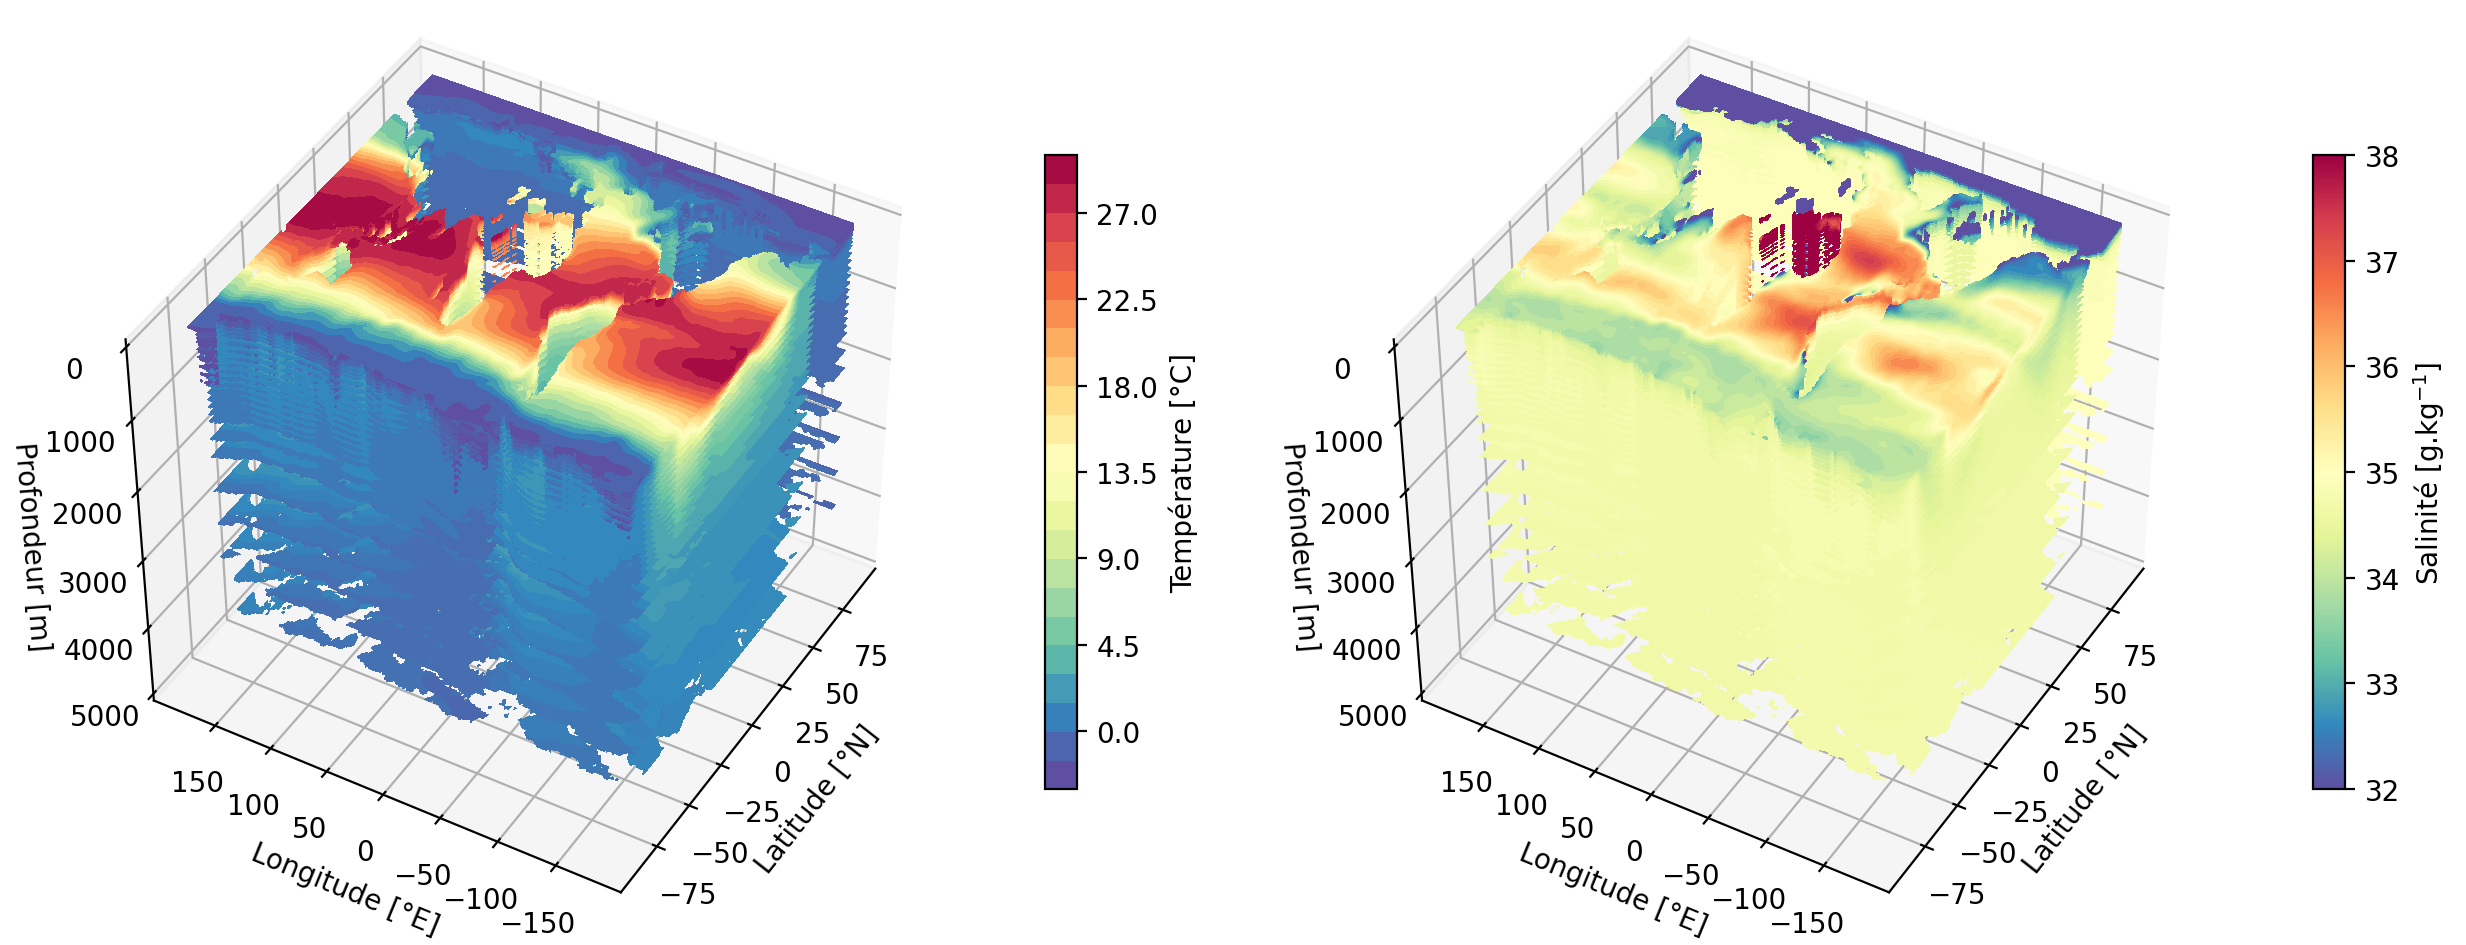

In [5]:
lonlon,latlat = np.meshgrid(longitude,latitude)

fig = plt.figure(figsize=(15,6),dpi=200)

ax = fig.add_subplot(121,projection='3d')
maxi,mini = np.nanmax(temperature),np.nanmin(temperature)
for i in range(int(np.sum(profondeur<5000)))[::-1]:
    c = ax.contourf(latlat,lonlon,np.array(temperature[i]), zdir='z', levels = 30,
                    offset=int(profondeur[i]), cmap=plt.cm.Spectral_r,vmin=mini,vmax=maxi)

plt.colorbar(c, fraction=0.03, label = "Température [°C]")
ax.set_xlabel("Latitude [°N]"),ax.set_ylabel("Longitude [°E]"),ax.set_zlabel("Profondeur [m]")
ax.set_zlim(5000, 0),ax.view_init(45, 210)

ax = fig.add_subplot(122)
c = ax.pcolormesh(longitude,latitude,np.array(salinite[i]), cmap=plt.cm.Spectral_r,vmin=32,vmax=38)

ax = fig.add_subplot(122,projection='3d')
for i in range(int(np.sum(profondeur<5000)))[::-1]:
    ax.contourf(latlat,lonlon,np.array(salinite[i]), zdir='z', levels = 300,
                offset=int(profondeur[i]), cmap=plt.cm.Spectral_r,vmin=32,vmax=38)

plt.colorbar(c, fraction=0.03, label = "Salinité [g.kg$^{-1}$]")
ax.set_xlabel("Latitude [°N]"),ax.set_ylabel("Longitude [°E]"),ax.set_zlabel("Profondeur [m]")
ax.set_zlim(5000, 0),ax.view_init(45, 210)
plt.show()

## 3.b Fonctions

Pour manipuler plus rapidement les données, on peut créer et utiliser des fonctions. Tout les fonctions prennent en argument des données (data) à choisir entre: temperature, salinite, densite et N2.

* Section_transervale: Faire une section verticale entre deux points de l'espace
* Section_latitude: Faire une section verticale le long d'une latitude fixée
* Section_longitude: Faire une section verticale le long d'une longitude fixée
* Profiles: Représente les profils verticaux en plusieurs coordonées
* Section_profondeur: Faire une section horizontale à une profondeur fixée


### 3.b.i. Section_transervale:

La fonction **Section_transervale** permet d'effectuer une section verticale entre deux points de l'espace.

Elle prend en argument les longitudes et latitudes bornant la coupe, ainsi que les données étudiées:
* Les longitudes (*°E*) doivent être comprise entre -180 et 180.
* Les latitudes (*°N*) doivent être comprise entre -90 et 90.
* Les données sont à choisir parmis: temperature et salinite

In [9]:
def Section_transervale(data ,lon_a, lon_b, lat_a, lat_b, vmin = None, vmax = None):
    data = data.to_dataset()
    start,end,steps = (lat_a, lon_a),(lat_b, lon_b), 1000
    cross_data = cross_section(data, start, end,steps=steps)
    
    L = np.sqrt(((lat_b-lat_a)* 111.11)**2+((lon_b-lon_a)*111.11*np.cos((lat_a+lat_b)/2))**2)/steps
    val = [i for i in data.data_vars][0]
    
    fig= plt.figure(figsize=(20, 6), dpi=200)
    
    ax = fig.add_subplot(1,5,5,projection=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE),ax.set_extent([-180,180,-90,90])
    ax.set_xticks(np.linspace(-180,180,5), crs=ccrs.PlateCarree())
    ax.set_yticks(np.linspace(-90,90,5), crs=ccrs.PlateCarree())
    ax.set_xlabel("Longitude [°E]"), ax.set_ylabel("Latitude [°N]")
    ax.scatter([lon_a,lon_b],[lat_a,lat_b], c = ['r','g']),ax.plot([lon_a,lon_b],[lat_a,lat_b], c = 'k')
    
    ax = fig.add_subplot(1,5,(1,4))
    ii,dd = np.meshgrid(cross_data.index,cross_data.depth)
    c = ax.pcolormesh(ii*L, dd, cross_data[val],cmap=plt.cm.Spectral_r, vmin = vmin, vmax = vmax)
    plt.colorbar(c,orientation='vertical',aspect=30, label = data[val].long_name+' ['+data[val].units+']')
    ax.scatter([0,(ii*L)[-1,-1]],[0,0], c = ['r','g'], s = 300)
    ax.set_xlabel('Distance [$km$]'),ax.set_ylabel('Profondeur [$m$]')
    ax.set_xlim(cross_data.index[[0,-1]]*L),ax.set_ylim(np.nanmax(dd),np.nanmin(dd))

Par exemple, pour faire une coupe de la température entre -20°E et -30°E de longitude et -80°N et 70°N de latitude:

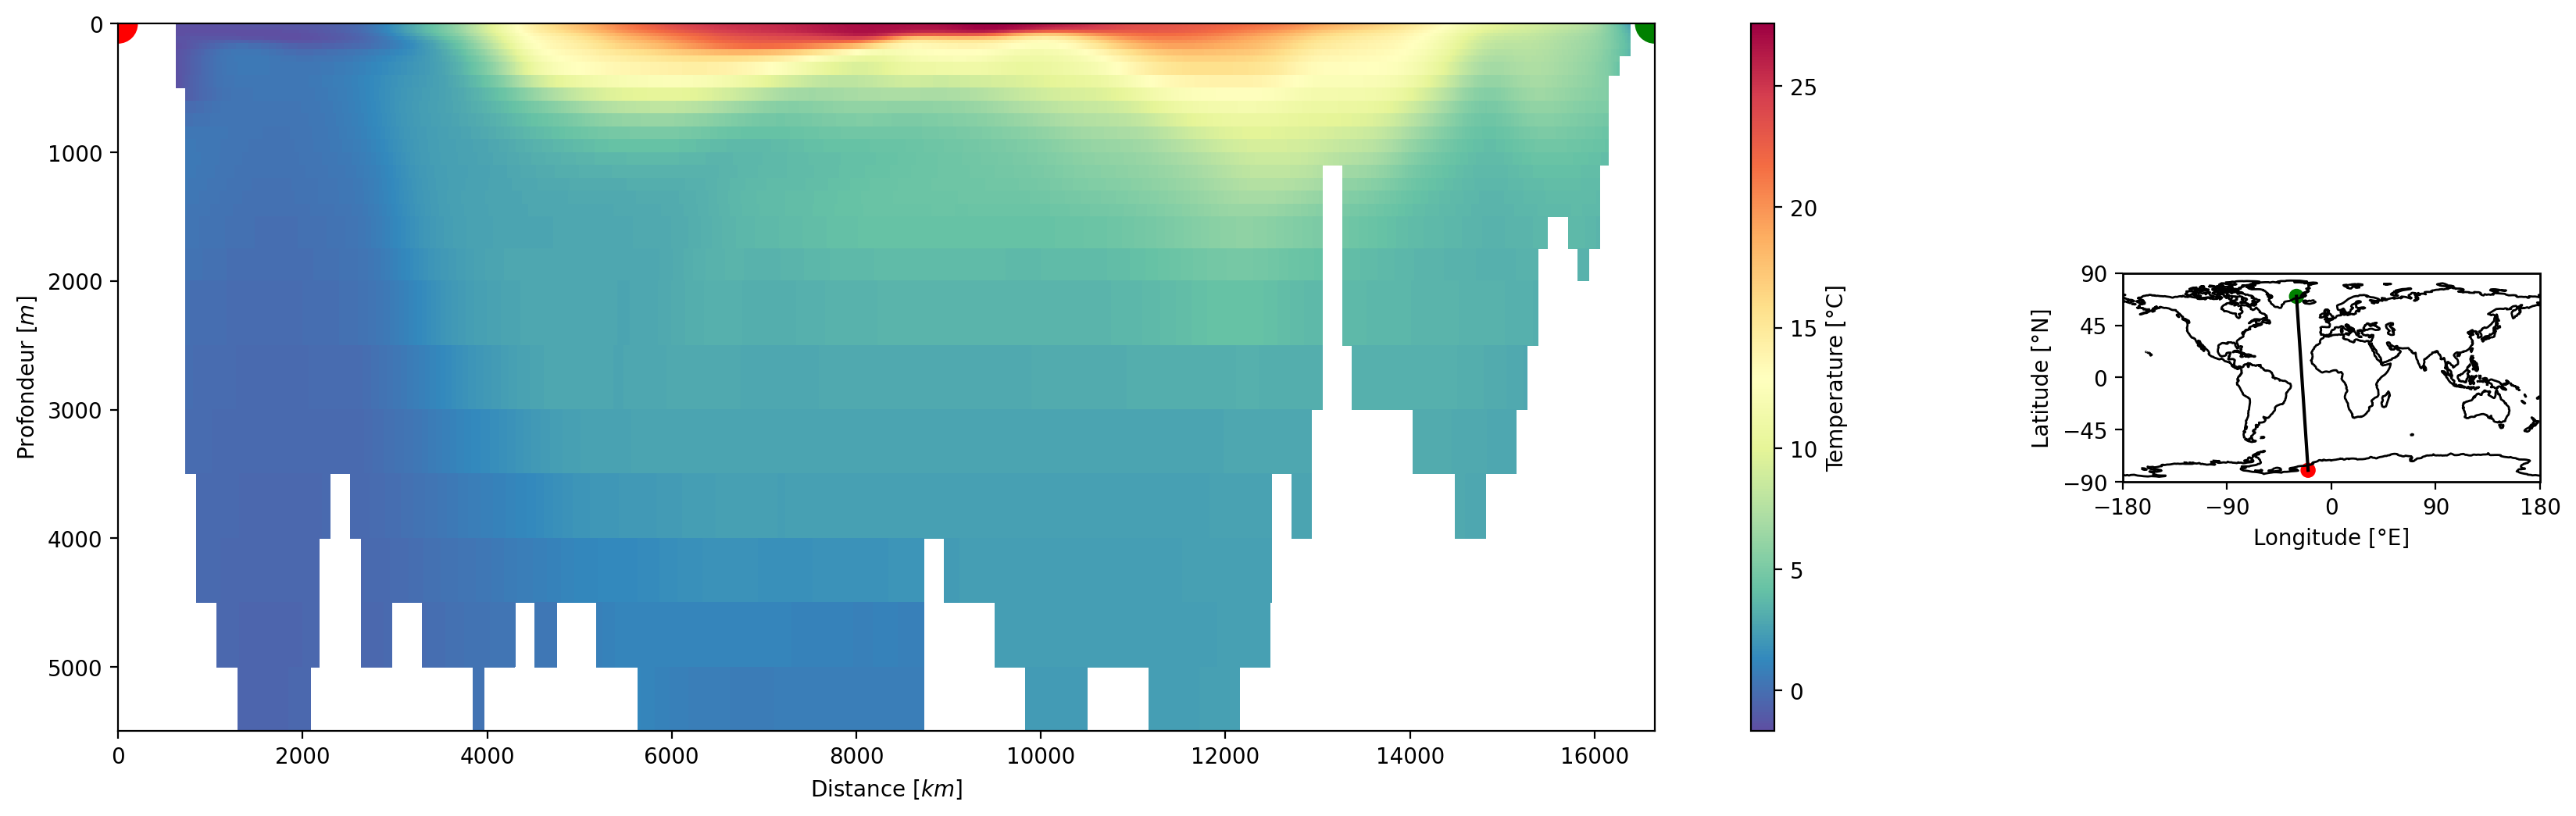

In [10]:
Section_transervale(data = temperature, lon_a = -20, lon_b = -30, lat_a = -80, lat_b = 70)

### 3.b.ii. Section_latitude: 

La fonction **Section_latitude** permet d'effectuer une section verticale le long d'une latitude fixée.

Elle prend en argument les longitudes et la latitude bornant la coupe, ainsi que les données étudiées:
* Les longitudes (*°E*) doivent être comprise entre -180 et 180.
* La latitude (*°N*) doit être comprise entre -90 et 90.
* Les données sont à choisir parmis: temperature et salinite

In [11]:
def Section_latitude(data , lat, lon_a, lon_b, vmin = None, vmax = None):
    inf = int(np.linspace(0,len(data.lat)-1,len(data.lat))[data.lat > lat][0])
    sup = int(np.linspace(0,len(data.lat)-1,len(data.lat))[data.lat <= lat][-1])
    l_inf,l_sup = data.lat[inf],data.lat[sup]
    
    value = ((l_sup-lat)/(l_sup-l_inf)*data[:,inf] + (lat-l_inf)/(l_sup-l_inf)*data[:,sup])
    
    fig= plt.figure(figsize=(20, 6), dpi=200)
    
    ax = fig.add_subplot(1,5,5,projection=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE),ax.set_extent([-180,180,-90,90])
    ax.set_xticks(np.linspace(-180,180,5), crs=ccrs.PlateCarree())
    ax.set_yticks(np.linspace(-90,90,5), crs=ccrs.PlateCarree())
    ax.set_xlabel("Longitude [°E]"), ax.set_ylabel("Latitude [°N]")
    ax.scatter([lon_a,lon_b],[lat,lat], c = ['r','g']),ax.plot([lon_a,lon_b],[lat,lat], c = 'k')
    
    ax = fig.add_subplot(1,5,(1,4))
    c = ax.pcolormesh(data.lon, data.depth, value,cmap=plt.cm.Spectral_r, vmin = vmin, vmax = vmax)
    plt.colorbar(c,orientation='vertical',aspect=30, label = data.long_name+' ['+data.units+']')
    ax.scatter([lon_a,lon_b],[0,0], c = ['r','g'], s = 300)
    ax.set_xlabel('Longitude [$°E$]'),ax.set_ylabel('Profondeur [$m$]')
    ax.set_xlim(lon_a,lon_b),ax.set_ylim(np.max(data.depth),0)


Par exemple, pour faire une coupe de la température entre -45°E et 160°E de longitude, à la latitude -45°N:

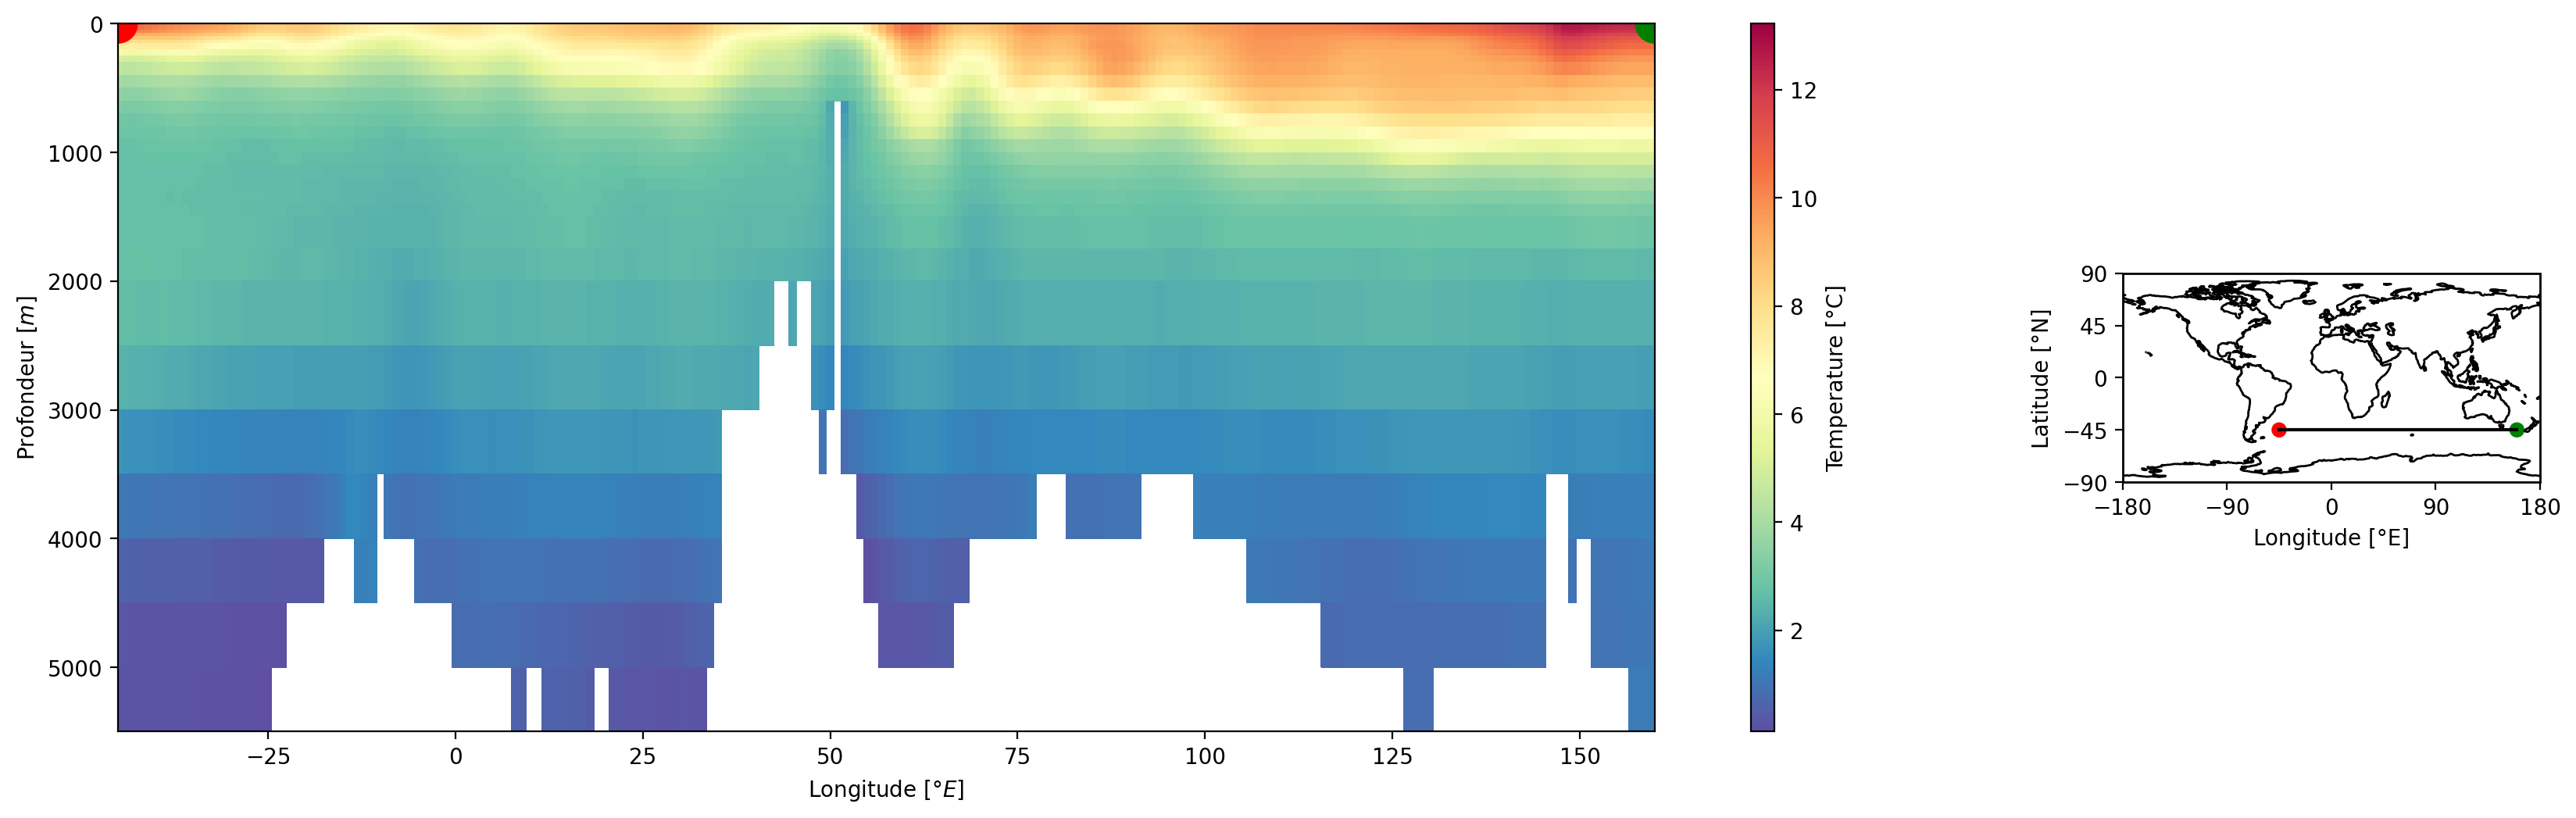

In [12]:
Section_latitude(data = temperature, lat = -45, lon_a = -45, lon_b = 160)

### 3.b.iii. Section_longitude:

La fonction **Section_longitude** permet d'effectuer une section verticale le long d'une longitude fixée.

Elle prend en argument la longitude et les latitudes bornant la coupe, ainsi que les données étudiées:
* La longitude (*°E*) doit être comprise entre -180 et 180.
* Les latitudes (*°N*) doivent être comprise entre -90 et 90.
* Les données sont à choisir parmis: temperature et salinite

In [13]:
def Section_longitude(data, lon, lat_a, lat_b, vmin = None, vmax = None):
    inf = int(np.linspace(0,len(data.lon)-1,len(data.lon))[data.lon > lon][0])
    sup = int(np.linspace(0,len(data.lon)-1,len(data.lon))[data.lon <= lon][-1])
    l_inf,l_sup = data.lon[inf],data.lon[sup]
    
    value = ((l_sup-lon)/(l_sup-l_inf)*data[:,:,inf] + (lon-l_inf)/(l_sup-l_inf)*data[:,:,sup])
    
    fig= plt.figure(figsize=(20, 6), dpi=200)
    
    ax = fig.add_subplot(1,5,5,projection=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE),ax.set_extent([-180,180,-90,90])
    ax.set_xticks(np.linspace(-180,180,5), crs=ccrs.PlateCarree())
    ax.set_yticks(np.linspace(-90,90,5), crs=ccrs.PlateCarree())
    ax.set_xlabel("Longitude [°E]"), ax.set_ylabel("Latitude [°N]")
    ax.scatter([lon,lon],[lat_a,lat_b], c = ['r','g']),ax.plot([lon,lon],[lat_a,lat_b], c = 'k')
    
    ax = fig.add_subplot(1,5,(1,4))
    c = ax.pcolormesh(data.lat, data.depth, value, cmap=plt.cm.Spectral_r, vmin = vmin, vmax = vmax)
    plt.colorbar(c,orientation='vertical',aspect=30, label = data.long_name+' ['+data.units+']')
    ax.scatter([lat_a,lat_b],[0,0], c = ['r','g'], s = 300)
    ax.set_xlabel('Latitude [$°N$]'),ax.set_ylabel('Profondeur [$m$]')
    ax.set_xlim(lat_a,lat_b),ax.set_ylim(np.max(data.depth),0)

Par exemple, pour faire une coupe de la temperature entre -35°N et -80°N de latitude, à la longitude -35°N:

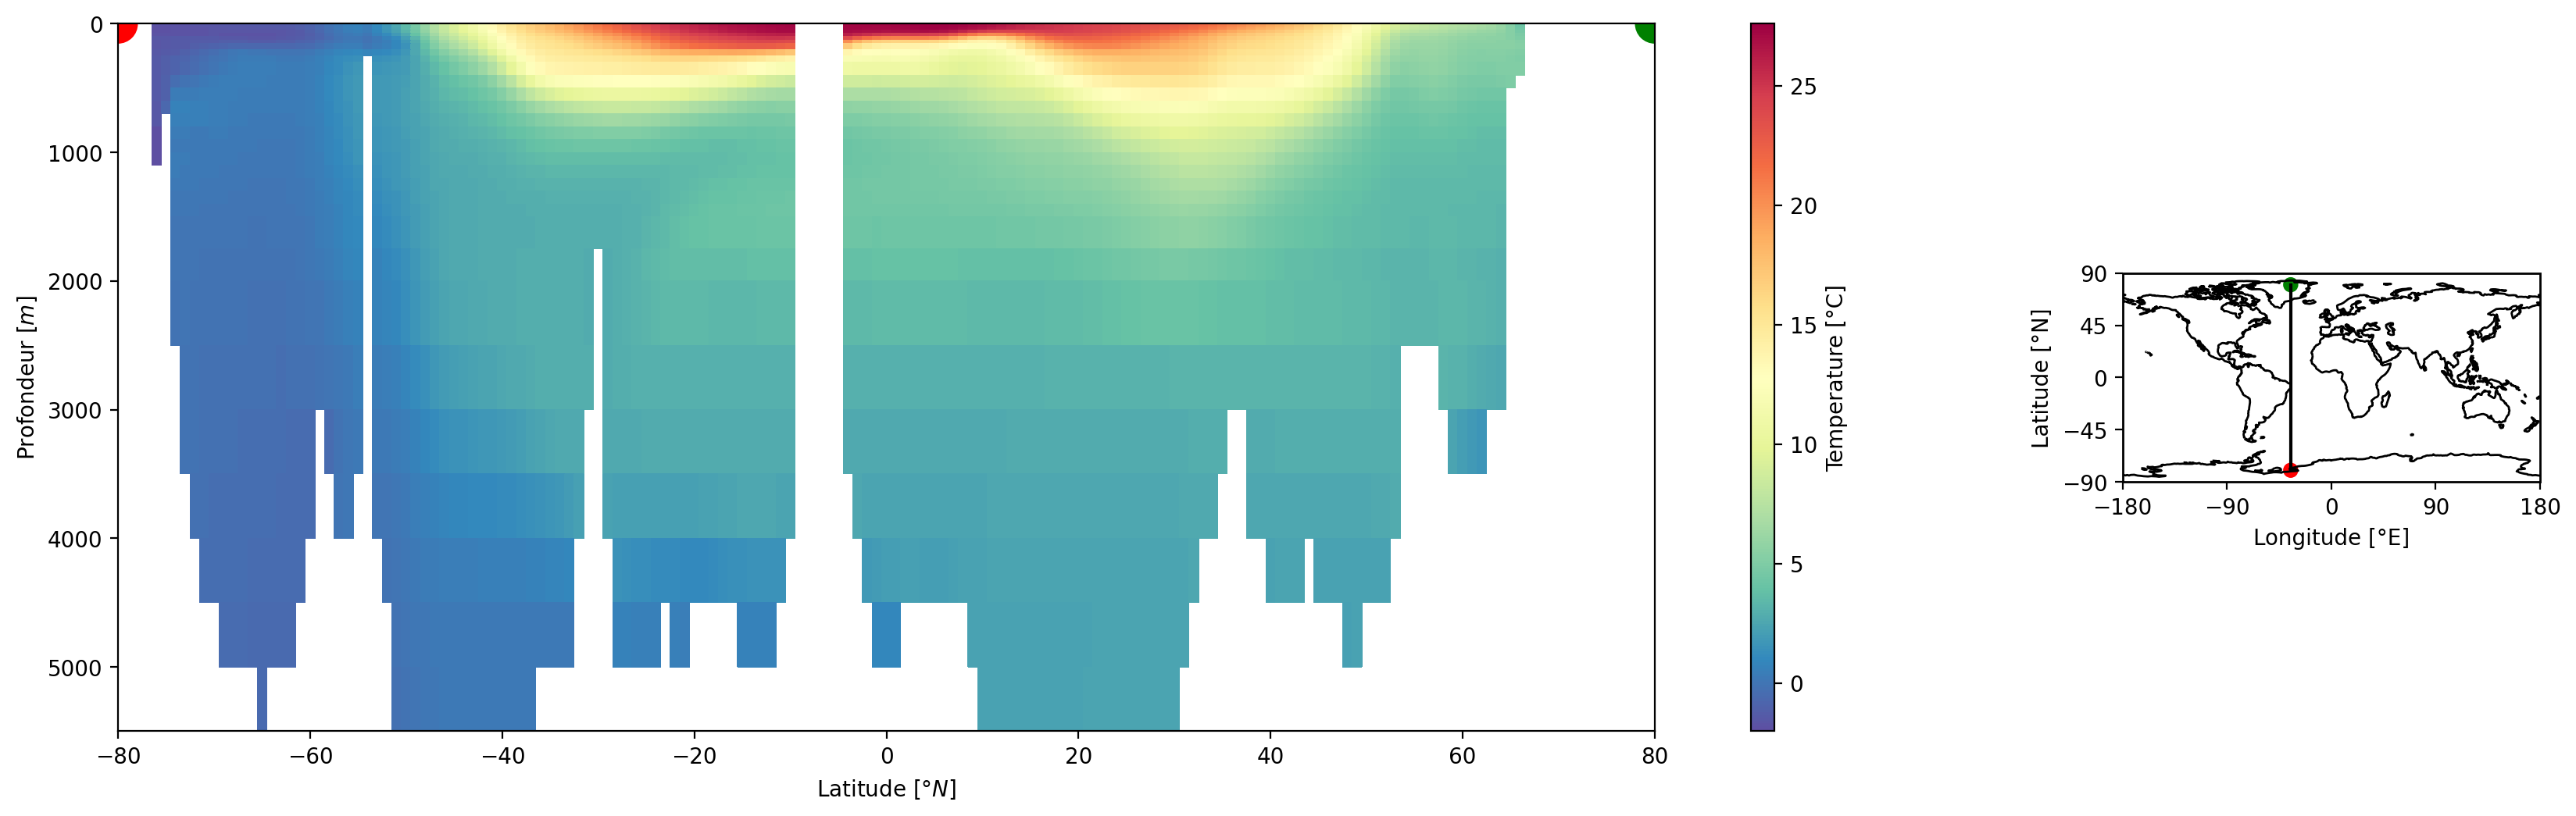

In [14]:
Section_longitude(data = temperature , lon = -35, lat_a = - 80, lat_b = 80)

### 3.b.iv. Profiles: 

La fonction **Profiles** permet de représenter les profils verticaux en plusieurs coordonées

Elle prend en argument les longitudes et latitudes des différents points, ainsi que les données étudiées:
* Les longitudes (*°E*) doivent être comprise entre -180 et 180.
* Les latitudes (*°N*) doivent être comprise entre -90 et 90.
* Les données sont à choisir parmis: temperature et salinite

In [12]:
def Profiles(data, coords):
    fig= plt.figure(figsize=(12, 6), dpi=200)

    ax1 = fig.add_subplot(1,2,1,projection=ccrs.PlateCarree())
    ax1.add_feature(cfeature.COASTLINE),ax1.set_extent([-180,180,-90,90])
    ax1.set_xticks(np.linspace(-180,180,5), crs=ccrs.PlateCarree())
    ax1.set_yticks(np.linspace(-90,90,5), crs=ccrs.PlateCarree())
    ax1.set_xlabel("Longitude [°E]"), ax1.set_ylabel("Latitude [°N]")

    ax2 = fig.add_subplot(1,2,2)
    ax2.set_ylim(4000, 0),ax2.set_ylabel('Profondeur [m]')
    ax2.set_xlabel(data.long_name+" ["+data.units+"]")

    for (lon,lat) in coords:
        ax1.scatter(lon,lat)

        x_inf = int(np.linspace(0,len(data.lon)-1,len(data.lon))[data.lon > lon][0])
        x_sup = int(np.linspace(0,len(data.lon)-1,len(data.lon))[data.lon <= lon][-1])
        y_inf = int(np.linspace(0,len(data.lat)-1,len(data.lat))[data.lat > lat][0])
        y_sup = int(np.linspace(0,len(data.lat)-1,len(data.lat))[data.lat <= lat][-1])

        lon_inf,lon_sup,lat_inf,lat_sup = data.lon[x_inf], data.lon[x_sup], data.lat[y_inf], data.lat[y_sup]
        f_ii,f_si,f_is,f_ss = data[:,y_inf,x_inf], data[:,y_inf,x_sup], data[:,y_sup,x_inf], data[:,y_sup,x_sup]
        dx, dy, Dx, Dy = lon - lon_inf, lat - lat_inf, lon_sup - lon_inf, lat_sup - lat_inf
        dfx, dfy, dfxy = f_si - f_ii, f_is - f_ii, f_ii + f_ss - f_si - f_is
        f = f_ii + dfx*dx/Dx + dfy*dy/Dy + dfxy*(dx*dy)/(Dx*Dy)
        
        ax2.plot(f,data.depth)

Par exemple, pour faire les profiles de salinité en (-40,45), (-100,-45) et (90,0):

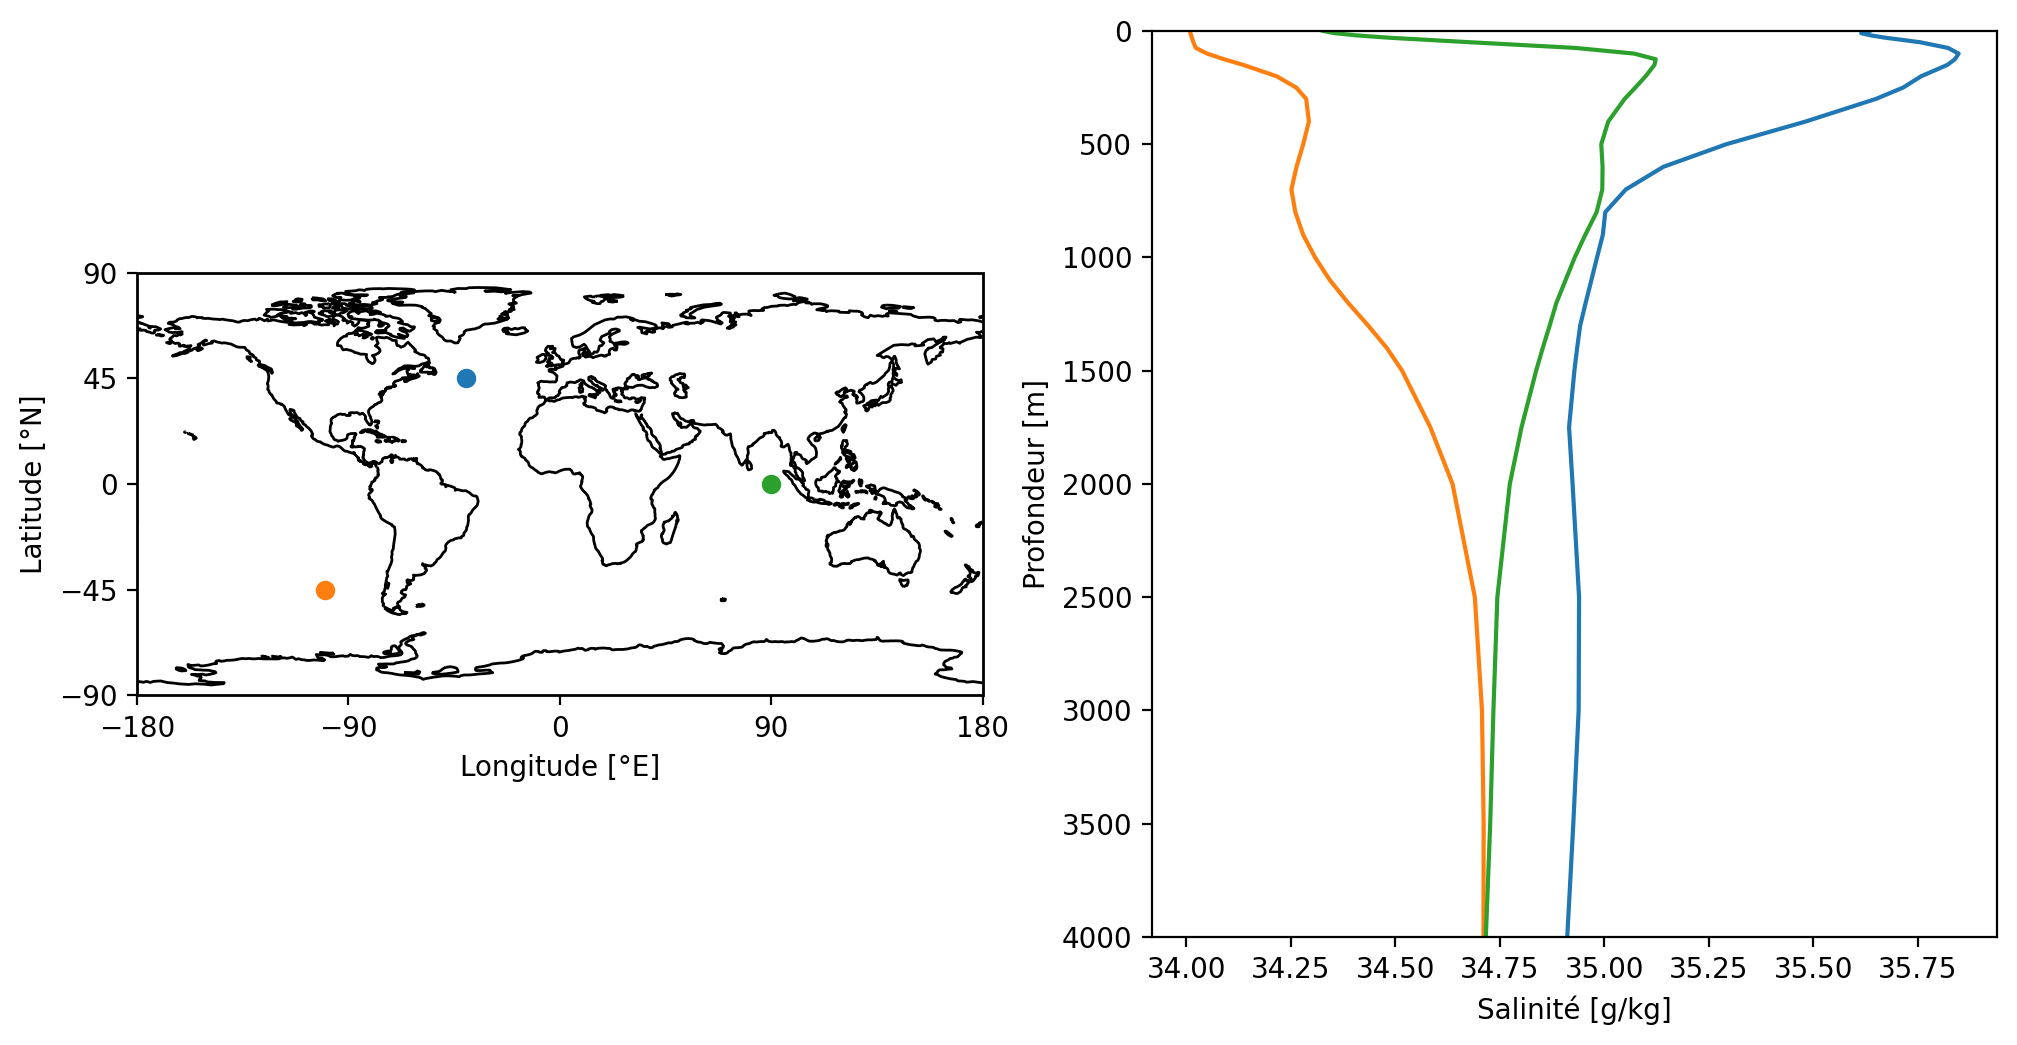

In [13]:
Profiles(data = salinite, coords = [(-40,45),(-100,-45),(90,0)])

### 3.b.v. Section_profondeur: 

La fonction **Section_profondeur** permet de réaliser une coupe à une profondeur fixée

Elle prend en argument la profondeur ainsi que les données étudiées:
* La profondeur doit être indiquée en mètre
* Les données sont à choisir parmis: temperature et salinite

In [14]:
def Section_profondeur(data, depth, vmin = None, vmax = None):
    inf = int(np.linspace(0,len(data.depth)-1,len(data.depth))[data.depth > depth][0])
    sup = int(np.linspace(0,len(data.depth)-1,len(data.depth))[data.depth <= depth][-1])
    l_inf,l_sup = data.depth[inf],data.depth[sup]
    
    value = (l_sup-depth)/(l_sup-l_inf)*data[inf] + (depth-l_inf)/(l_sup-l_inf)*data[sup]
    
    fig = plt.figure(figsize=(12,5), dpi = 200)
    ax = fig.add_subplot(111, projection = ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND),ax.add_feature(cfeature.COASTLINE)
    ax.set_yticks([-90, -45, 0, 45, 90], crs = ccrs.PlateCarree())

    value_cyc, lon_cyc = cutil.add_cyclic_point(value, coord=data.lon)
    c = ax.pcolormesh(lon_cyc, data.lat, value_cyc, vmin = vmin, vmax = vmax, cmap = plt.cm.Spectral_r)
    plt.colorbar(c, label = data.long_name+" ["+data.units+"]")

Par exemple, pour faire une coupe de la température à 400 m de profondeur:

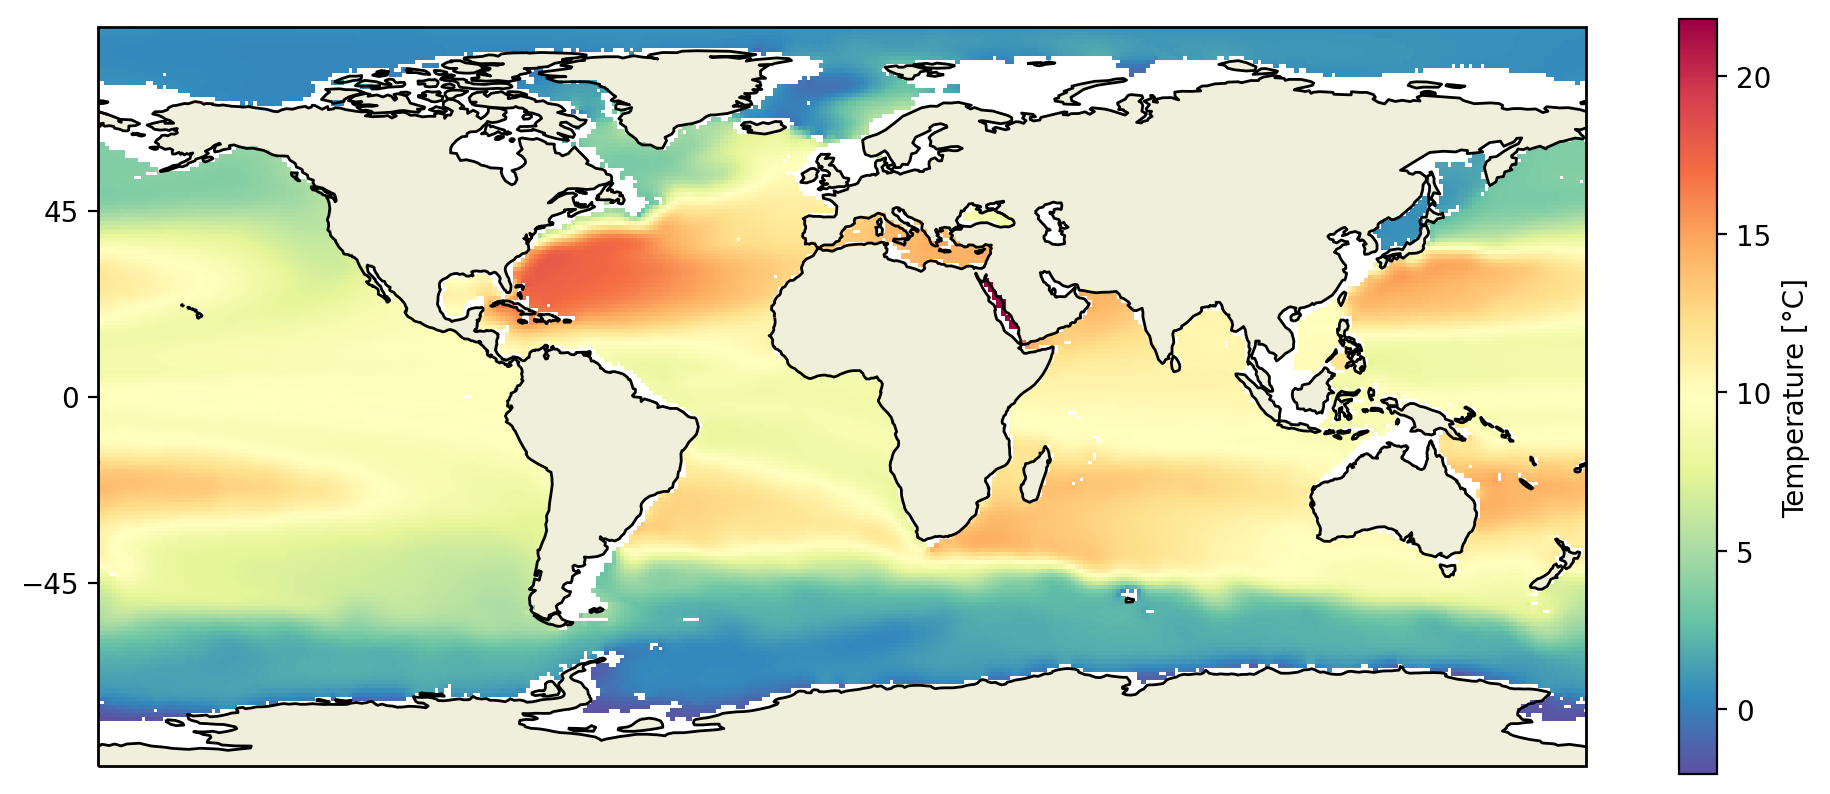

In [15]:
Section_profondeur(data = temperature, depth = 400)

# 4. Exploitation des données <a id='Exploitation'></a>

[Retour au menu](#Plan)

En utilisant les données et les fonctions précédement présentées ci-dessus, répondez aux questions suivantes:

## 4.a. L'océan de surface

**Distribution de température**
- Expliquer le distribution latitudinale de température
- Donner une hypothèse sur l'apparition de température plus faible à l'est des bassins pour une latitude donnée

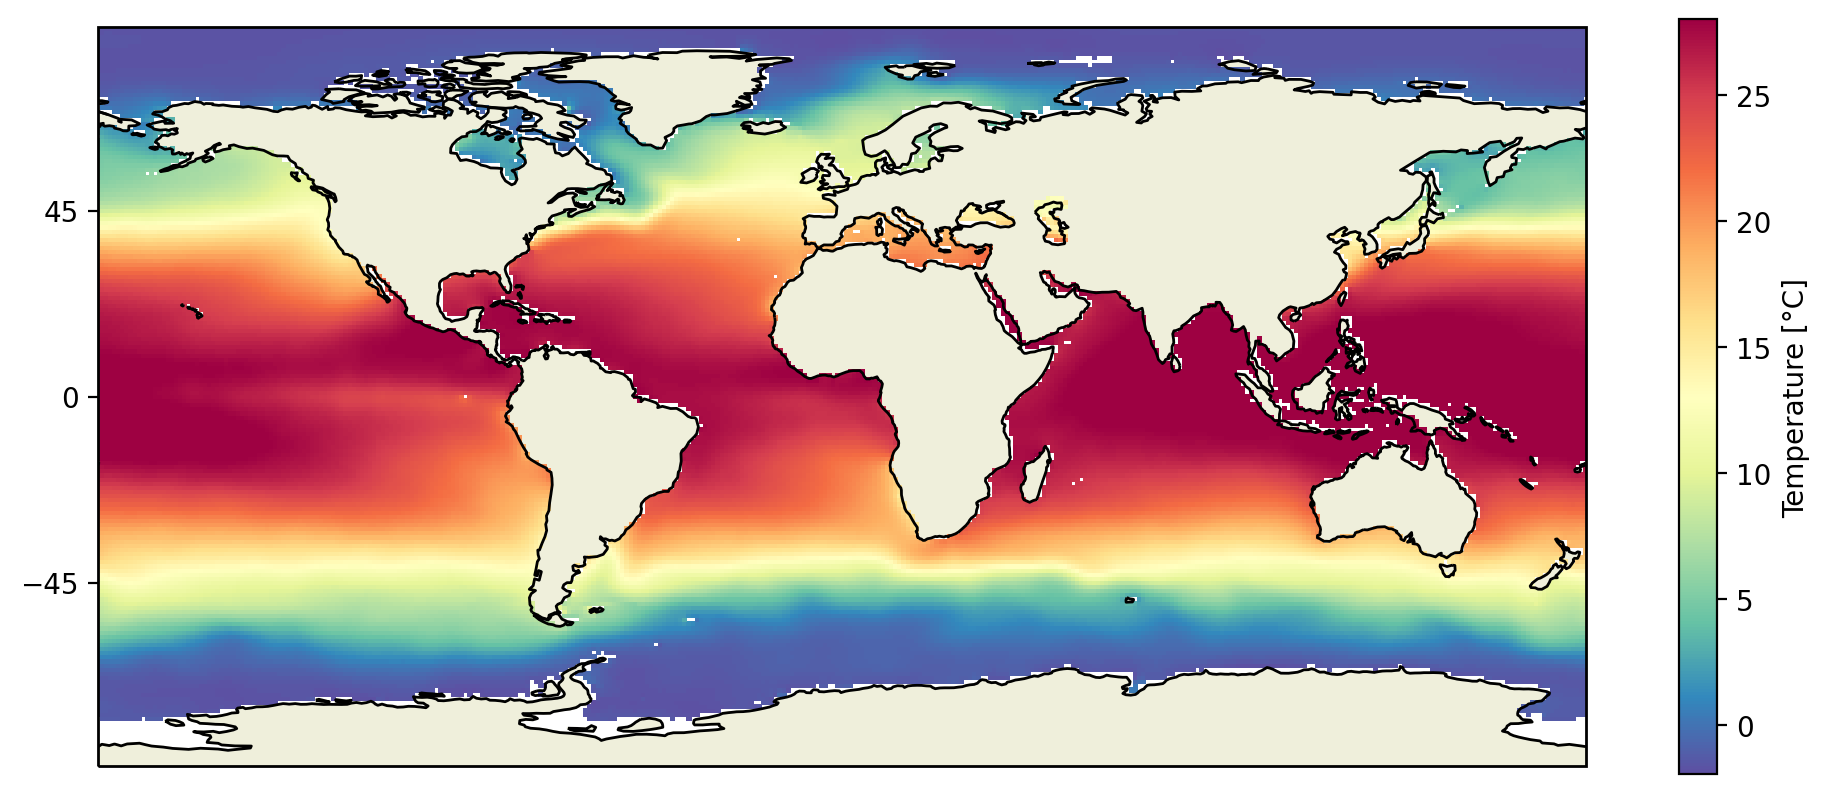

In [16]:
Section_profondeur(data = temperature, depth = 0, vmax = 28)

**Distribution de salinité**
- Expliquer la forte salinité de la mer méditéranée.
- A quoi correspondent les faibles salinité au Nord du Brésil ou à l'Est de l'Inde ?
- Dans l'Atlantique, pourquoi la salinité est plus forte vers 30° qu'à l'équateur ?

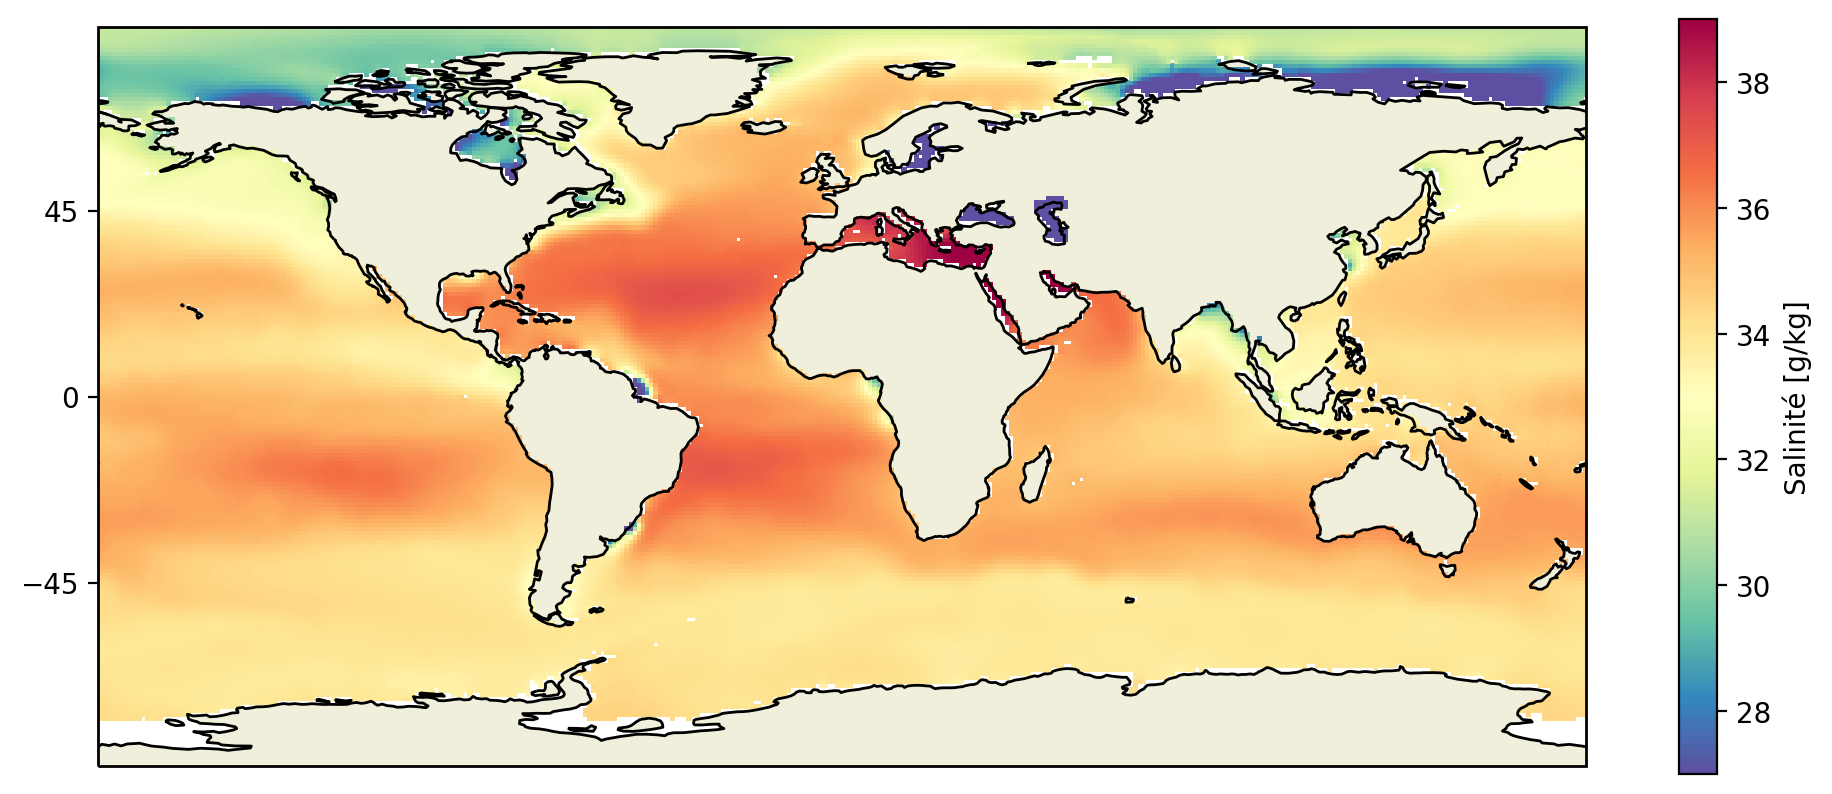

In [17]:
Section_profondeur(data = salinite, depth = 0, vmin = 27, vmax = 39)

## 4.b. En profondeur

**Profiles de température et de salinité**
* Comment se comportent les profiles de température et de salinité en profondeur ?
* A quelle profondeur les profiles changent-ils majoritairement de valeur ?

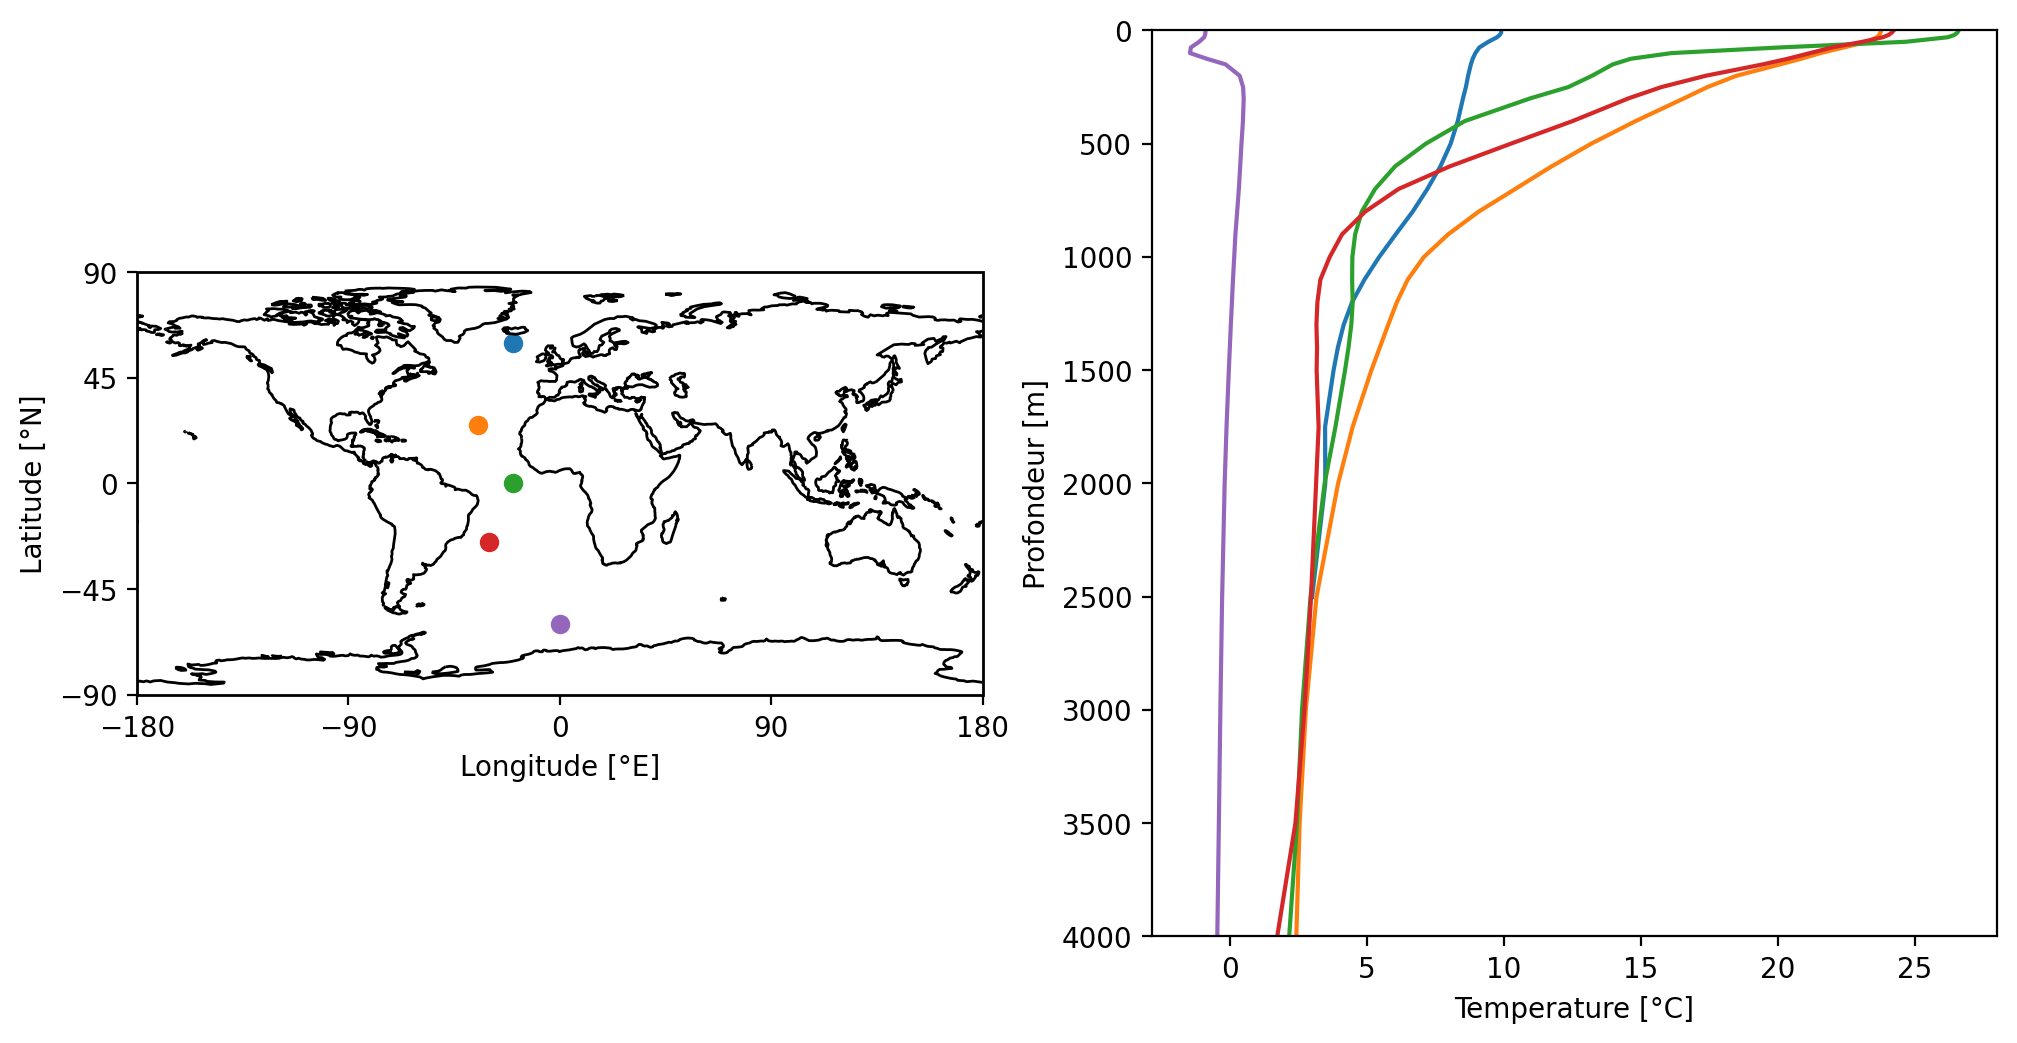

In [18]:
Profiles(data = temperature, coords = [(-20,60),(-35,25),(-20,0),(-30,-25),(-0,-60)])

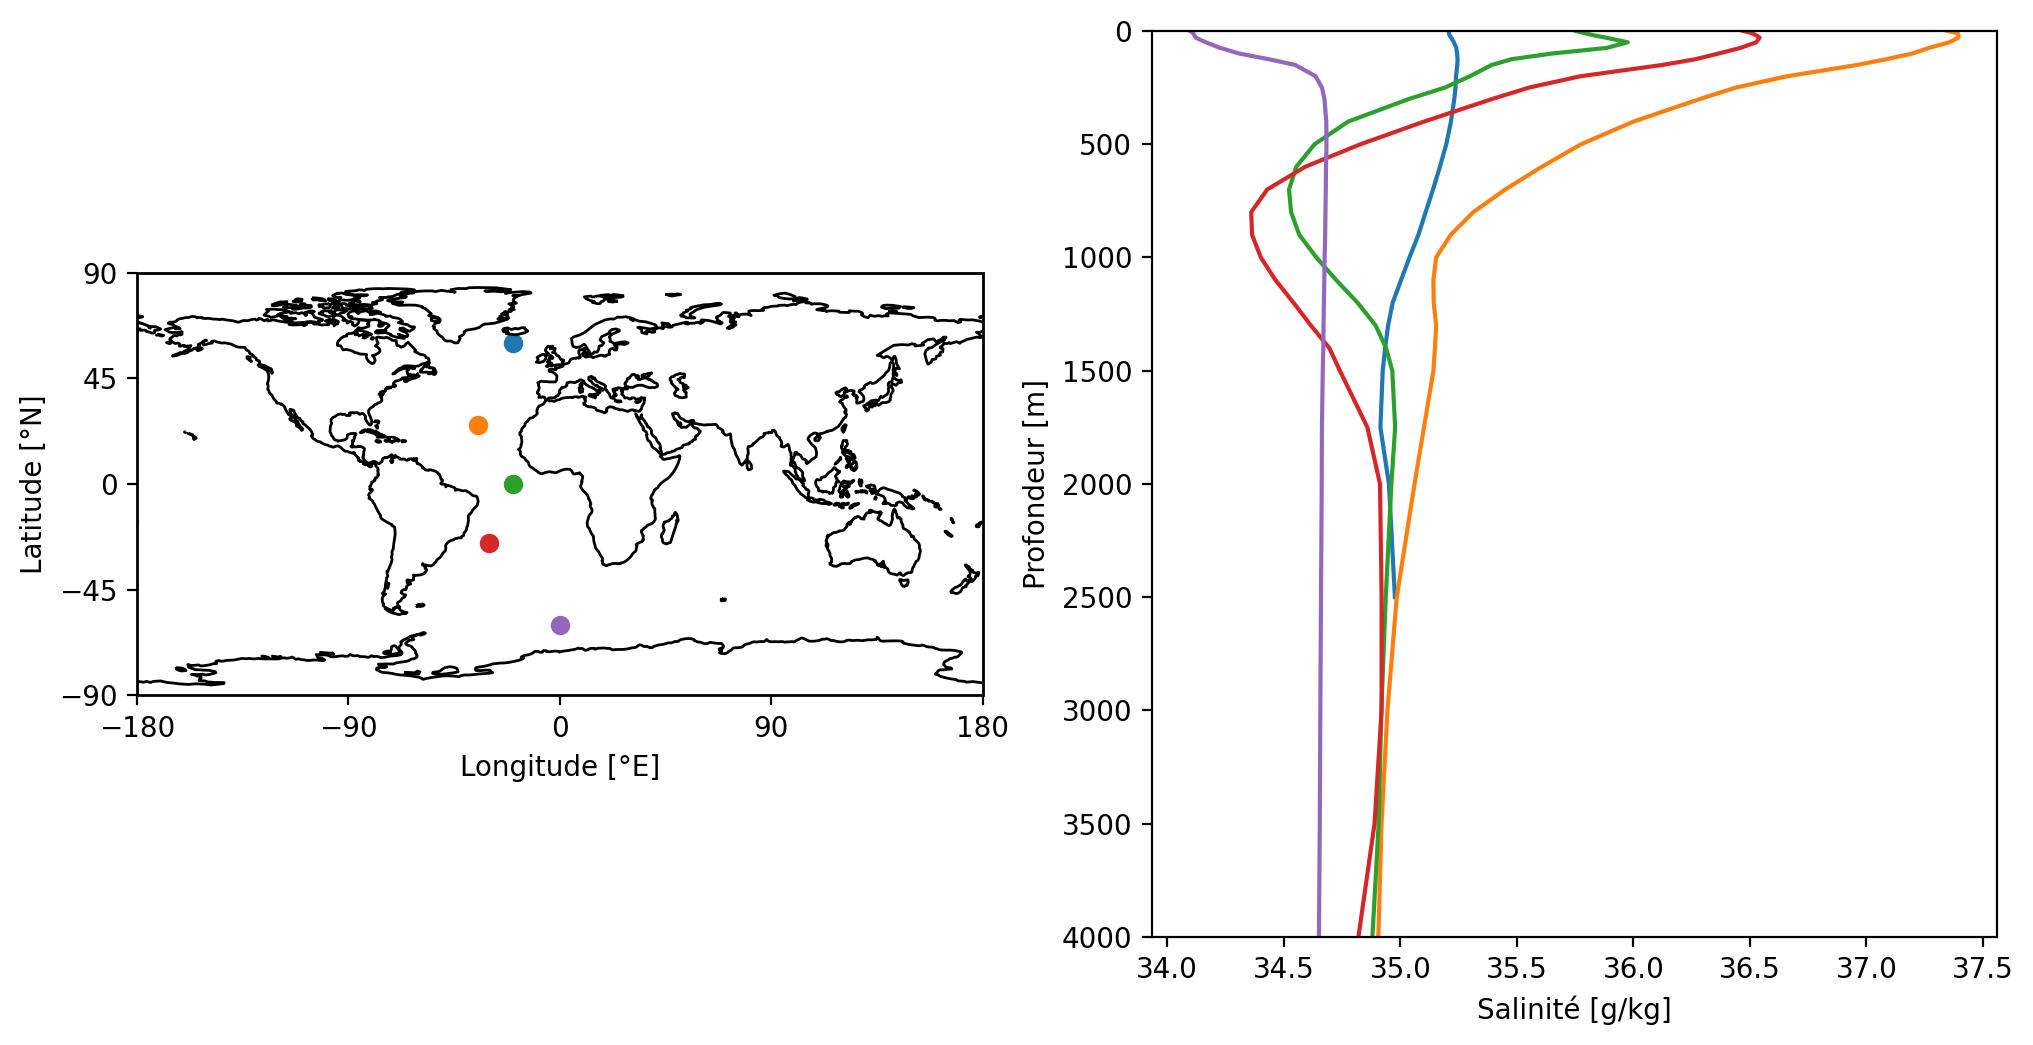

In [19]:
Profiles(data = salinite, coords = [(-20,60),(-35,25),(-20,0),(-30,-25),(-0,-60)])

## 4.c. Formation d'eau profonde
**Identification de masses d'eau**
* Grâce aux données de température et de salinité, identifier les différentes masses d'eau de l'océan Atlantique
* Quel semble être leur trajet ?

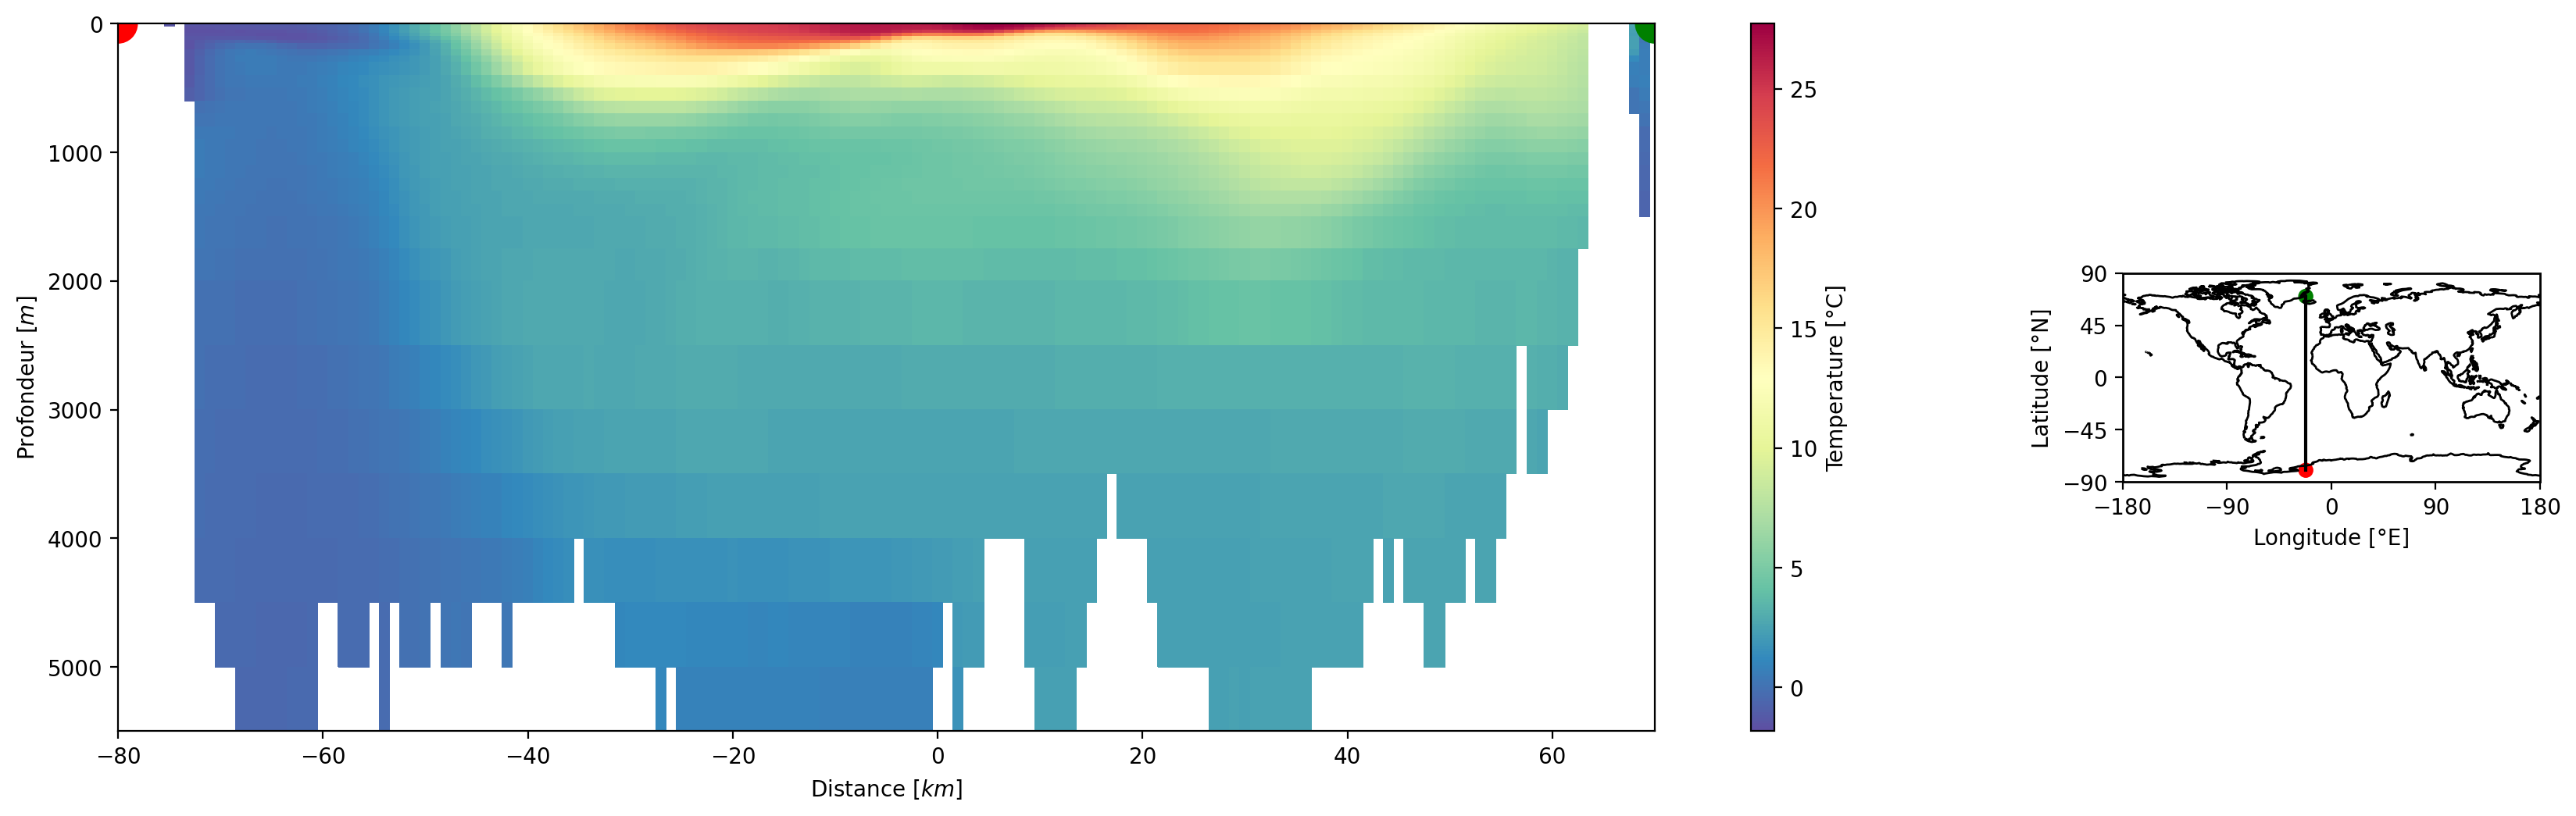

In [20]:
Section_longitude(data = temperature, lon = -22, lat_a = -80, lat_b = 70)

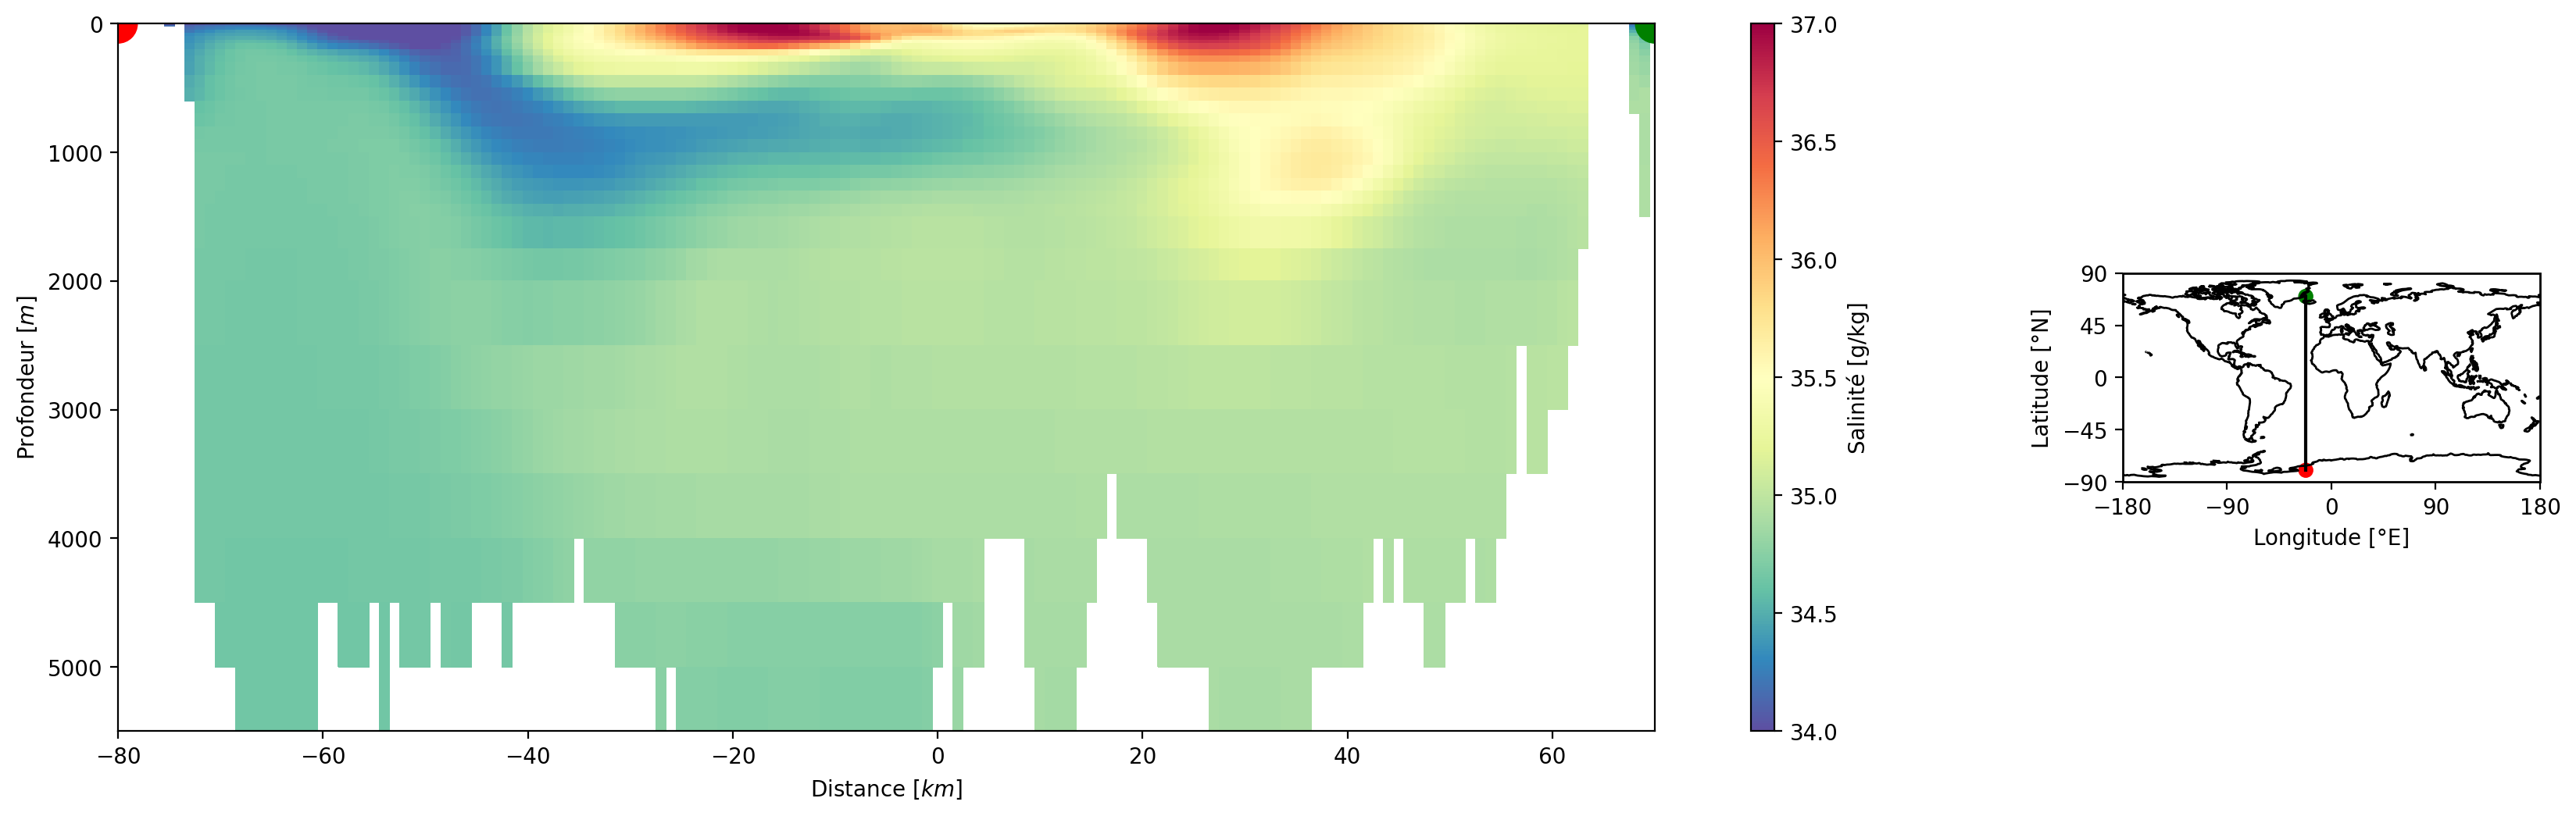

In [21]:
Section_longitude(data = salinite, lon = -22, lat_a = -80, lat_b = 70, vmin = 34, vmax = 37)

## 4.d. Mouvements d'eau verticaux

* Comment expliquer la structure verticale de la température dans le Pacifique tropical, le long des côtes de Péru ?

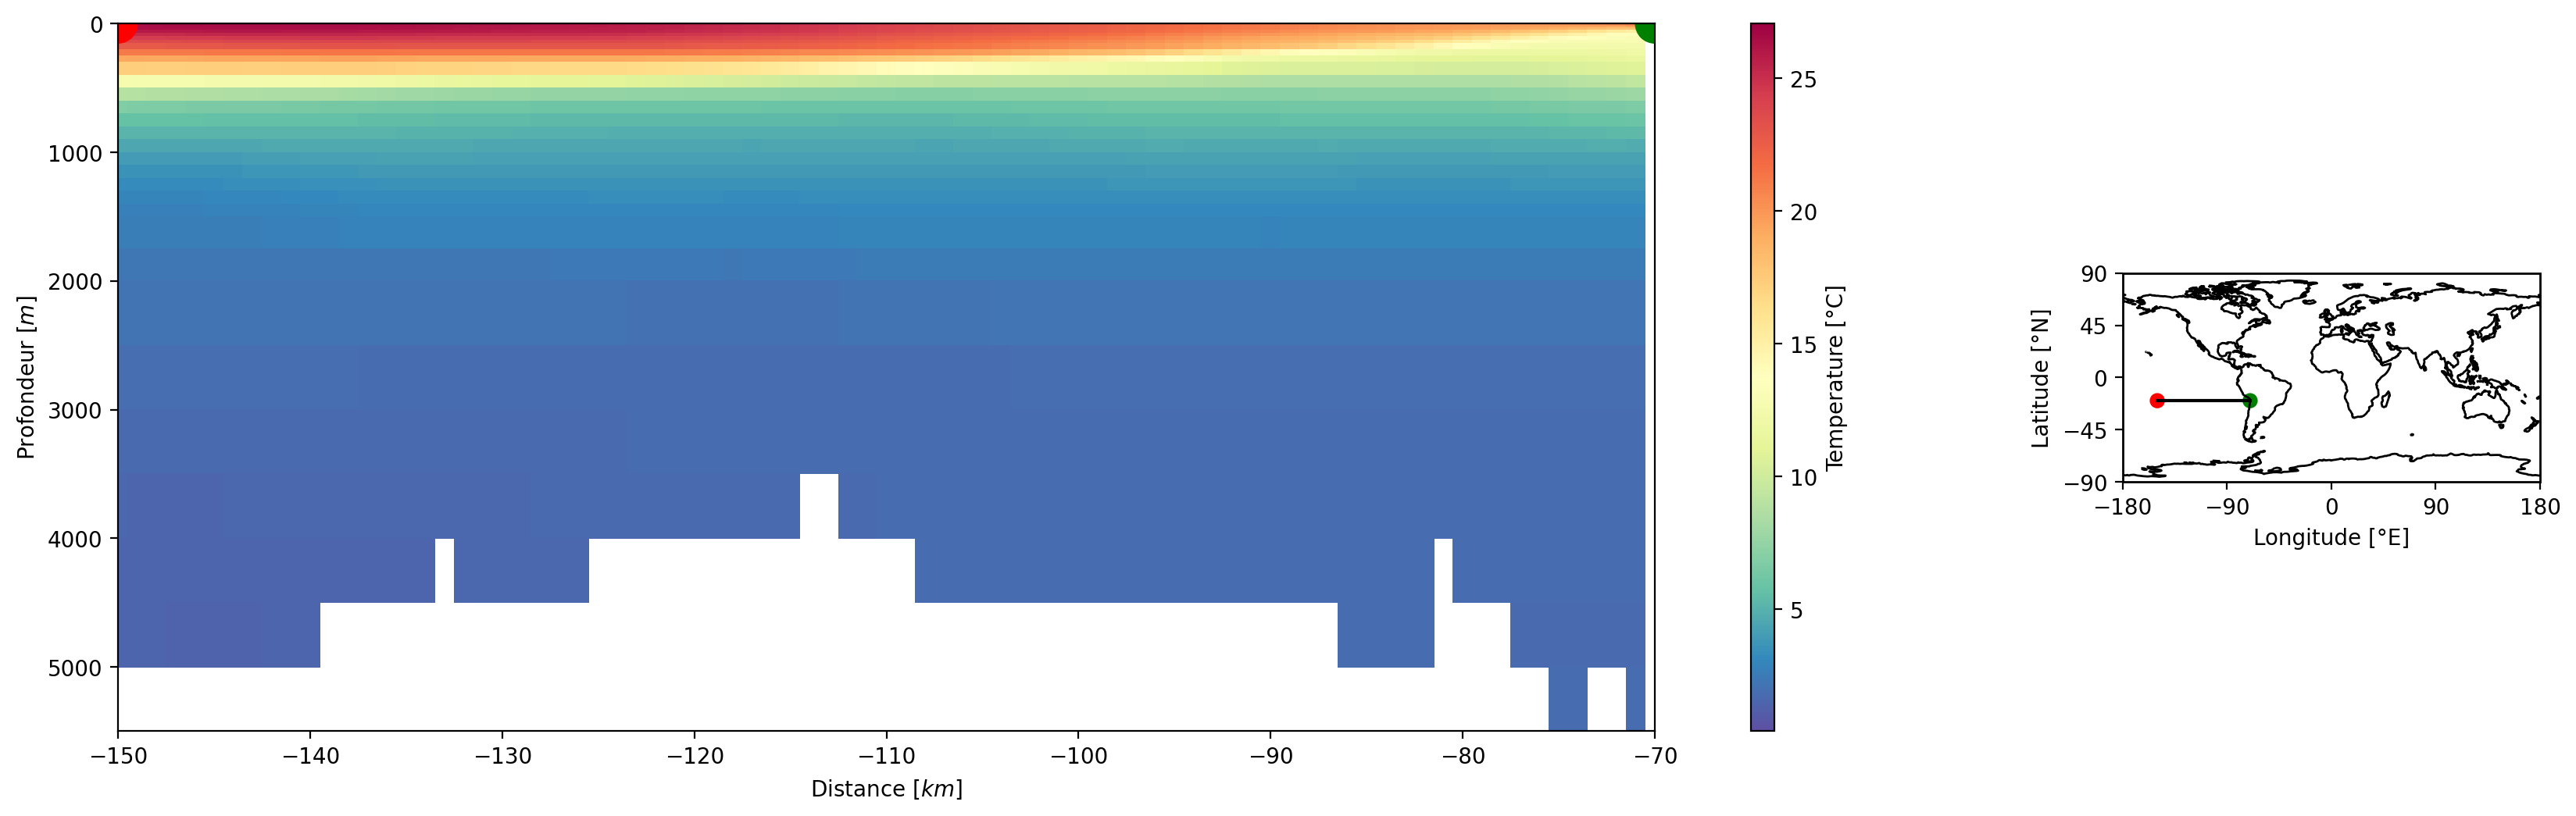

In [22]:
Section_latitude(data = temperature, lon_a = -150, lon_b = -70, lat = -20)

* Comment expliquer la structure verticale de la température dans l'Atltantique Nord ?

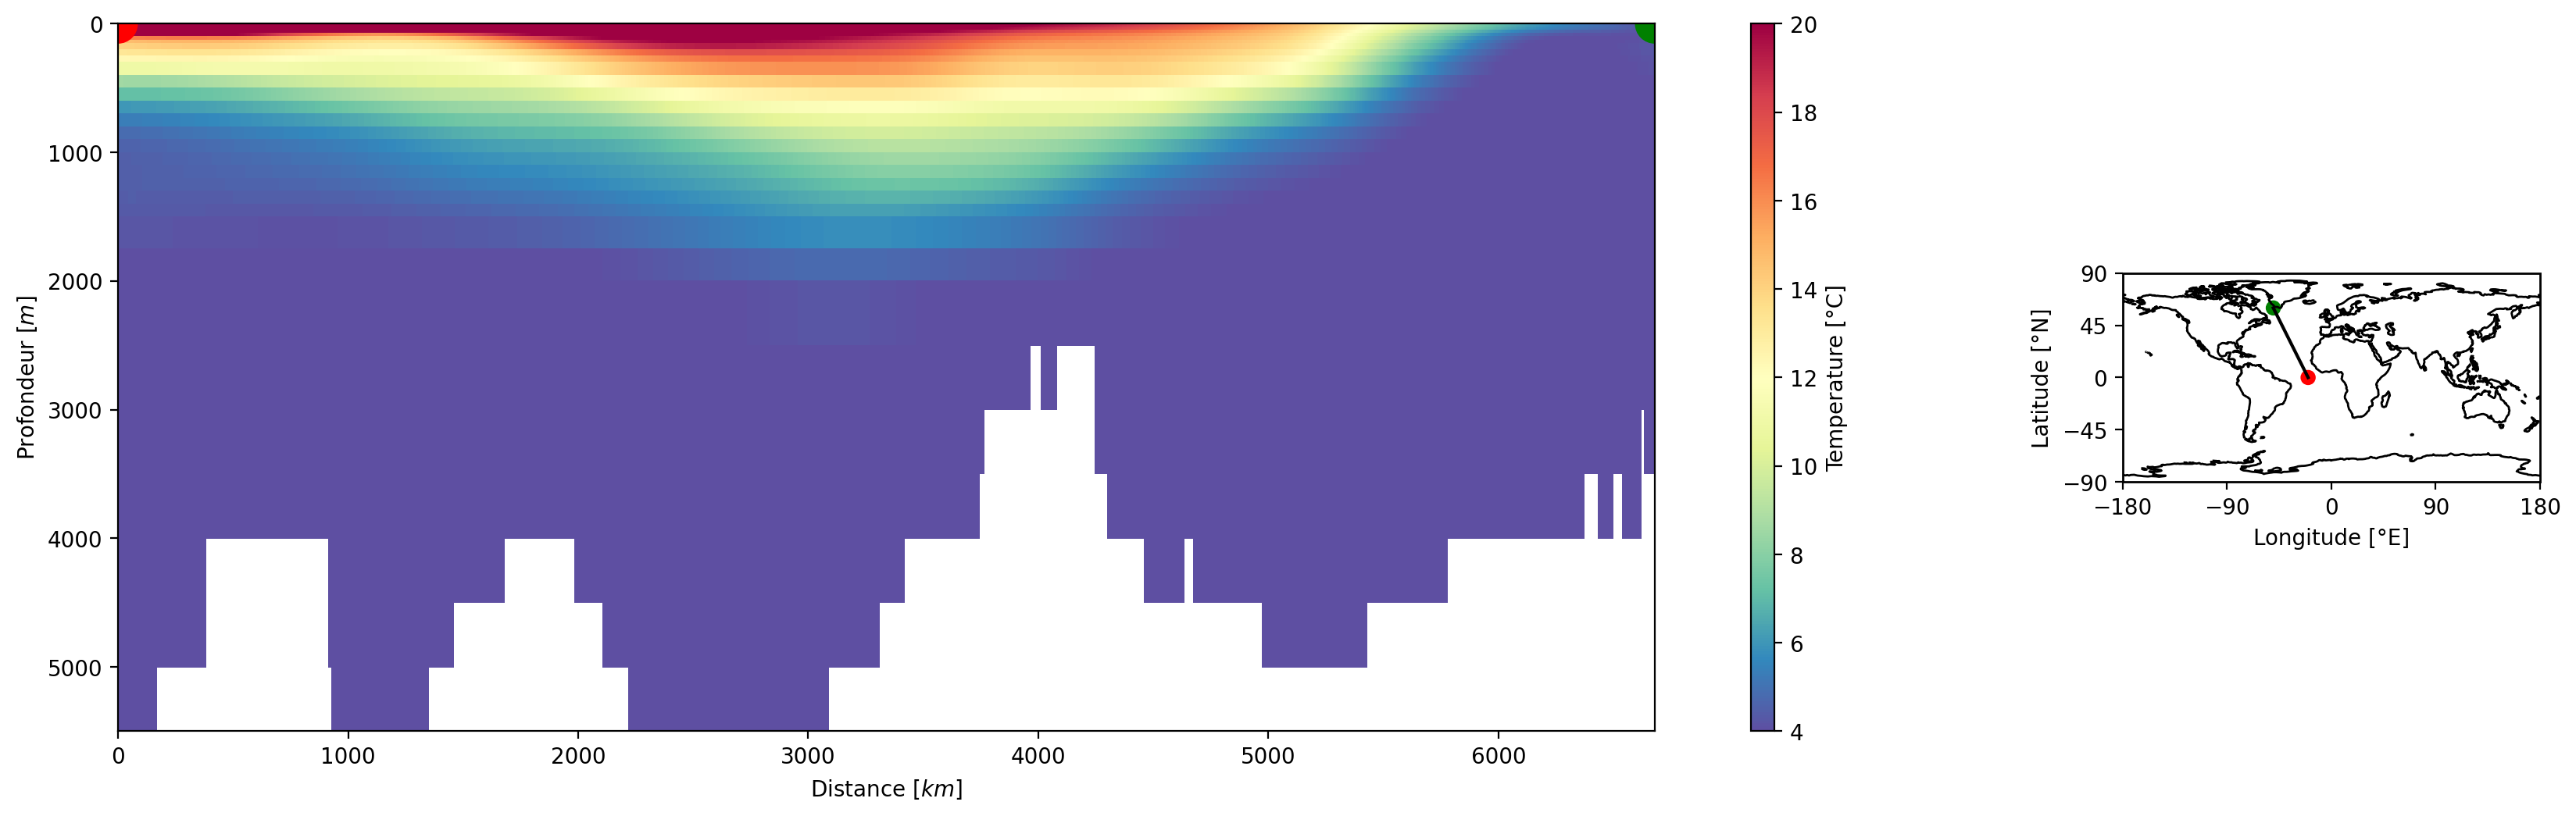

In [23]:
Section_transervale(data = temperature, lon_a = -20, lon_b = -50, lat_a = 0, lat_b = 60, vmin = 4, vmax = 20)

# 5. Aller plus loin <a id='Extra'></a>

[Retour au menu](#Plan)

Avec les quelques fonctions précédement définies, vous pouver étudier librement ces données

In [24]:
"""
Espace de code
"""

'\nEspace de code\n'